In [1]:
# Bibliotecas

import pandas as pd
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.tokens import Doc
import stanza
import nltk
from nltk.corpus import stopwords  
from tqdm import tqdm
import re
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
import random
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nuno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nuno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nuno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1 Análise de Sentimento

### 1.1 Dados

amazon_reviews: Conjunto não balanceado, com cerca de 50000 reviews de produtos da empresa Amazon, anotadas com as etiquetas “positive” e “negative”.

In [8]:
import pandas as pd

# Carregar os dados de treino
train_data = pd.read_csv("amazon_reviews_train.csv")

# Carregar os dados de teste
test_data = pd.read_csv("amazon_reviews_test.csv")

In [8]:
# Verificar o tamanho dos dados
print(train_data.shape)
print(test_data.shape)

(48902, 2)
(2417, 2)


In [9]:
# Verificar os NA no conjunto de treino
print("Null values:",train_data.isnull().values.sum())
print("NA values:", train_data.isna().values.any())

# Verificar os NA no conjunto de teste
print("Null values:",test_data.isnull().values.sum())
print("NA values:", test_data.isna().values.any())

Null values: 0
NA values: False
Null values: 0
NA values: False


In [10]:
train_data.head()

,sentiment,review
0,negative,Product arrived labeled as Jumbo Salted Peanut...
1,positive,This is a confection that has been around a fe...
2,negative,If you are looking for the secret ingredient i...
3,positive,Great taffy at a great price. There was a wid...
4,positive,This saltwater taffy had great flavors and was...


In [11]:
# Número de documentos
num_docs_train = len(train_data)
num_docs_test = len(test_data)

print(f"Number of documents in training set: {num_docs_train}")
print(f"Number of documents in test set: {num_docs_test}")

# Distribuição de etiquetas
label_distribution_train = train_data['sentiment'].value_counts()
label_distribution_test = test_data['sentiment'].value_counts()

print("\nLabel distribution in training set:")
print(label_distribution_train)

print("\nLabel distribution in test set:")
print(label_distribution_test)

Number of documents in training set: 48902
Number of documents in test set: 2417

Label distribution in training set:
sentiment
positive    37835
negative    11067
Name: count, dtype: int64

Label distribution in test set:
sentiment
positive    1676
negative     741
Name: count, dtype: int64


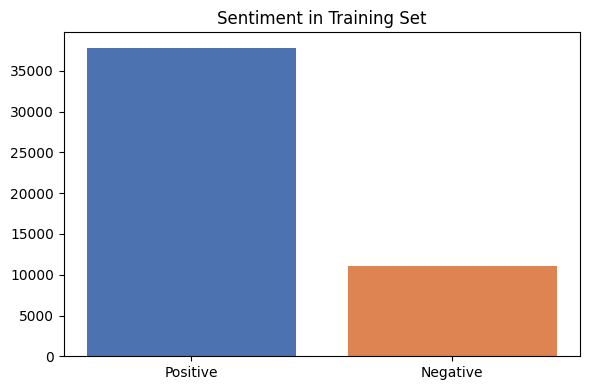

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('deep')

plt.figure(figsize=(6,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=train_data['sentiment'].value_counts(),
        color=colors[:2])
plt.title('Sentiment in Training Set')
plt.show()

Conjunto de treino não balanceado 

In [3]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Configura o undersampler
rus = RandomUnderSampler(random_state=42)

# Separa os dados e as etiquetas
X_train = train_data[['review']]
y_train = train_data['sentiment']

# Aplica o undersampling
X_res, y_res = rus.fit_resample(X_train, y_train)

# Verifica o novo balanceamento das classes
#print(pd.Series(y_res).value_counts())

# Criar um novo dataframe com os dados balanceados
train_data_balanced = pd.concat([X_res, pd.Series(y_res, name='sentiment')], axis=1)

print(train_data['sentiment'].value_counts())
print(train_data_balanced['sentiment'].value_counts())

sentiment
positive    37835
negative    11067
Name: count, dtype: int64
sentiment
negative    11067
positive    11067
Name: count, dtype: int64


### 1.2 Definição de um baseline usando ferramentas já existentes

- TextBlob
- Vader Sentiment
- Stanza

In [14]:
# Instalar biblioteca textblob
# !pip install textblob

In [15]:
# Instalar biblioteca vaderSentiment
# !pip install vaderSentiment

In [16]:
# Instalar biblioteca stanza
# !pip install stanza

In [17]:
# Bibliotecas
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# Verificar os nomes das colunas
print(test_data.columns)


# Função para prever o sentimento com TextBlob
def predict_sentiment(text):
    analysis = TextBlob(text)
    # TextBlob retorna polaridade dentro do intervalo [-1, 1], onde valores positivos indicam sentimentos positivos
    return "positive" if analysis.sentiment.polarity >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_TextBlob"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["sentiment"] = test_data["sentiment"].map({"positive": 1, "negative": 0})
test_data["predicted_sentiment_TextBlob"] = test_data["predicted_sentiment_TextBlob"].map({"positive": 1, "negative": 0})

print(test_data["sentiment"].value_counts())

# Calcular as métricas de avaliação
print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_TextBlob"] ))

Index(['sentiment', 'review'], dtype='object')
sentiment
1    1676
0     741
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       741
           1       0.77      0.94      0.85      1676

    accuracy                           0.76      2417
   macro avg       0.75      0.65      0.67      2417
weighted avg       0.76      0.76      0.74      2417



In [18]:
# Bibliotecas
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Inicializar o analisador de sentimentos VADER
analyzer = SentimentIntensityAnalyzer()


# Função para prever o sentimento com VADER
def predict_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return "positive" if scores["compound"] >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_VADER"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["predicted_sentiment_VADER"] = test_data["predicted_sentiment_VADER"].map({"positive": 1, "negative": 0})

print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_VADER"] ))

              precision    recall  f1-score   support

           0       0.82      0.39      0.53       741
           1       0.78      0.96      0.86      1676

    accuracy                           0.79      2417
   macro avg       0.80      0.68      0.70      2417
weighted avg       0.79      0.79      0.76      2417



In [19]:
# import pandas as pd
# import stanza
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# # Inicializar o pipeline NLP Stanza
# nlp = stanza.Pipeline("en", processors="tokenize,sentiment")


# # Função para prever o sentimento com Stanza
# def predict_sentiment(text):
#     doc = nlp(text)
#     sentiment_scores = [sentence.sentiment for sentence in doc.sentences]
#     avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
#     return "positive" if avg_sentiment >= 1 else "negative"


# # Aplicar a função de previsão de sentimento aos dados de teste
# test_data["predicted_sentiment_Stanza"] = test_data["review"].apply(predict_sentiment)

# # Converter rótulos de string para binários
# test_data["predicted_sentiment_Stanza"] = test_data["predicted_sentiment_Stanza"].map(
#     {"positive": 1, "negative": 0}
# )

# # Calcular as métricas de avaliação
# print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_Stanza"] ))

### 1.3 Preparação de dados e aplicação de um léxico de sentimentos

**Léxicos de polaridade** são recursos valiosos em processamento de linguagem natural (NLP), particularmente úteis para tarefas como análise de sentimentos, onde o objetivo é determinar a atitude ou emoção expressa em um texto. Esses léxicos consistem em listas de palavras, cada uma associada a uma pontuação ou etiqueta que indica se a palavra tem uma conotação positiva, negativa ou neutra. Alguns léxicos também incluem intensidades para refletir o grau de emoção. 

- NRC Word-Emotion Association Lexicon (EmoLex)

In [20]:
# Lista de palavras inglesas e o seu respetivo sentimento (positivo ou negativo)

emolex = pd.read_csv(
    "NCR-lexicon.txt",
    skiprows=0,
    sep="\t",
)

emolex = emolex[["English Word", "negative", "positive"]]

emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex.head(10)

,English Word,negative,positive
0,aback,0,0
1,abacus,0,0
2,abandon,1,0
3,abandoned,1,0
4,abandonment,1,0
5,abate,0,0
6,abatement,0,0
7,abba,0,1
8,abbot,0,0
9,abbreviate,0,0


In [21]:
emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex_dict['happy']

(1, 0)

- Afinn Lexicon ()

Este léxico atribui a cada palavra uma pontuação de -5 a 5, indicando a intensidade do sentimento negativo ou positivo. É útil em contextos onde a intensidade precisa ser medida.

In [22]:
afinn = pd.read_csv("Afinn.csv", encoding="latin1")

afinn.head(10)

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
5,abductions,-2
6,abhor,-3
7,abhorred,-3
8,abhorrent,-3
9,abhors,-3


In [23]:
afinn_dict = {row["word"]: row["value"] for index, row in afinn.iterrows()}

afinn_dict['happy']

3

- Bing Lexicon ()

Este léxico é frequentemente usado em análise de sentimentos para identificar e contar o número de palavras positivas e negativas em um texto.

In [24]:
bing = pd.read_csv("Bing.csv")

bing.head(10)

,word,sentiment
0,2-faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative
5,abominate,negative
6,abomination,negative
7,abort,negative
8,aborted,negative
9,aborts,negative


In [25]:
# Adiciona colunas binárias para os sentimentos
bing['negative'] = (bing['sentiment'] == 'negative').astype(int)
bing['positive'] = (bing['sentiment'] == 'positive').astype(int)

# Remove a coluna de sentimento
bing = bing.drop('sentiment', axis=1)

#bing.head(10)

bing_dict = {row["word"]: (row["positive"], row["negative"]) for index, row in bing.iterrows()}

bing_dict['happy']

(1, 0)

Pré-processamento

In [26]:
#!pip install wordcloud

**Wordclouds** testar no fim com os modelos e respetivo tratamento do texto

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

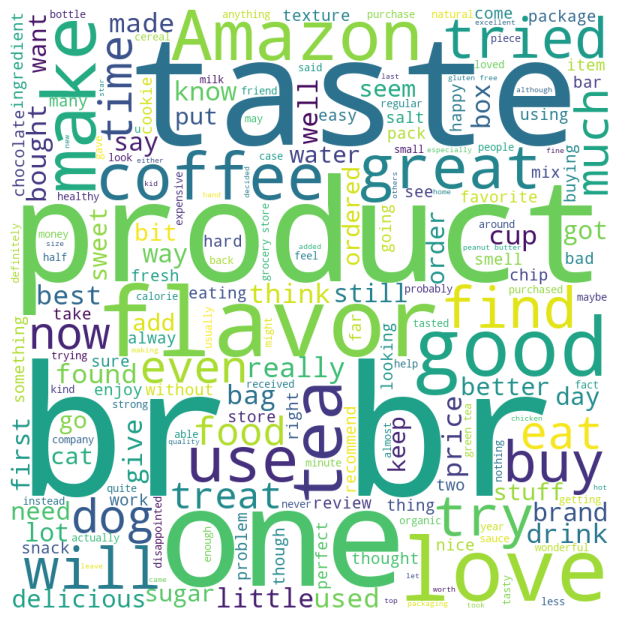

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatena todas as reviews em uma única string
text = " ".join(review for review in train_data['review'])

# Crie a instância WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

# Plote o WordCloud                    
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [28]:
from collections import Counter
import pandas as pd

# Top 20 palavras mais comuns
words = re.findall(r'\w+', ' '.join(train_data['review'].str.lower()))
top = Counter(words)
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,154572
1,i,142088
2,and,105446
3,a,100114
4,it,88910
5,to,82734
6,of,65062
7,is,59759
8,this,56492
9,br,48939


- Limpeza do texto

try and except: foi utilizado em quase todas as funções porque mais para a frente vamos fazer as combinações e por isso não vamos precisar sempre de tokenizar, vai bastar uma vez, então se der erro ele apenas passa o text para o words. O words essencialmente nesses casos vai ser já a lista de tokens

In [29]:
import re


# Função de limpeza de texto
def clean(text):
    
    # Transformar em minúsculas
    text = text.lower()
    # Remover código HTML
    text = re.sub(r"<[^>]+>", "", text)
    # Remover URLs
    text = re.sub(r"http\S+|www\S+|https?\:\/\/\S+", "", text)
    # Remover menções a usuários (não comum em reviews da Amazon)
    text = re.sub(r"@\w+", "", text)
    # Remover hashtags (também não comum em reviews da Amazon)
    text = re.sub(r"#\w+", "", text)
    # Remover entidades HTML (&amp;, &lt;, etc.)
    text = re.sub(r"&\w+;", "", text)
    # Remover números (avaliações numéricas, preços, etc.)
    text = re.sub(r"\d+", "", text)
    # Substituir caracteres de pontuação por espaços, exceto apostrofes dentro de palavras
    text = re.sub(r"[^\w\s']", " ", text)
    # Remover espaços múltiplos e linhas novas
    text = re.sub(r"\s+", " ", text)
    #Remover espaços no início e no fim
    text = text.strip()

    return text


# train_clean = train_data["review"].apply(clean)
# test_clean = test_data["review"].apply(clean)


# train_clean.to_csv(
#    "/Users/marianaborralho/Desktop/M. Ciencia de Dados/2 Semestre/Text Mining/Trabalho/train_clean.csv",
#    index=False,
# )
# test_clean.to_csv(
#    "/Users/marianaborralho/Desktop/M. Ciencia de Dados/2 Semestre/Text Mining/Trabalho/train_clean.csv",
#    index=False,
# )

In [30]:
train_data["review"][157]

"Hi, I have to have black tea everyday. I have done it in the past 25 years and it's a habit of mine. Ahmad tea is one of my favorite brands and I highly recommend it if you like black tea. I think this is going to remain my favorite for the next 100 years or so :)"

In [31]:
# train_clean[157]

- Tokenização

In [32]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download("punkt")


# Função de tokenização
def tokenize(text):
    return word_tokenize(text)


# train_tok = train_data["review"].apply(tokenize)

# test_tok = test_data["review"].apply(tokenize)

[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
# train_tok[18]

- StopWords

In [34]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
import nltk

# Função que remove stopwords
def remove_stopwords(text):
    
    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [word for word in words if word not in nltk_stopwords.words('english')]
    return words

# train_stopwords = train_data["review"].apply(remove_stopwords)
# test_stopwords = test_data["review"].apply(remove_stopwords)

In [35]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [36]:
# train_stopwords[28]

- Stemming

In [37]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# Função de stemming
def stem(text):
    stemmer = PorterStemmer()
    try:
        words = word_tokenize(text)
    except:
        words = text
    words = [stemmer.stem(word) for word in words]
    return words

# train_stem = train_data['review'].apply(stem)
# test_stem = test_data['review'].apply(stem)


In [38]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [39]:
# train_stem[28]

- Lematização

In [40]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Função de lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [lemmatizer.lemmatize(word, "v") for word in words]
    return words

# train_lemmatized = train_data["review"].apply(lemmatize)
# test_lemmatized = test_data["review"].apply(lemmatize)

In [41]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [42]:
# train_lemmatized[28]

- Contrações

In [43]:
#!pip install contractions

In [44]:
import contractions

# Função que trata das contrações
def expand_contractions(text):
    return contractions.fix(text)


# train_expanded = train_data["review"].apply(expand_contractions)
# test_expanded = test_data["review"].apply(expand_contractions)

In [45]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [46]:
# train_expanded[28]    

- POS tagging (Part-of-Speech tagging)

Foram removidas 3 classes: Preposições, Conjunções e Pronomes

Nota: Algumas destas classes podem ser removidas usando a função de stopwords (são muito comuns e geralmente não contribuem muito para o significado de uma frase)

Ver se faz sentido adicionar/retirar alguma classe
    


In [47]:
def pos_tagging(text):
    
    try:
        words = word_tokenize(text)
    except:
        words = text
    
    # Aplica o POS tagging a cada palavra
    pos_tags = nltk.pos_tag(words)

    # Filtra palavras que são preposições (IN), conjunções (CC) ou pronomes (PRP, PRP$)
    filtered_words = [word for word, tag in pos_tags if tag not in ['IN', 'CC', 'PRP', 'PRP$']]

    # Junta as palavras filtradas de volta em uma string
    return filtered_words

# Exemplo 
#text_example = "The quick brown fox jumps over the lazy dog"
#filtered_text = pos_tagging(text_example)
#print(filtered_text)

# train_pos = train_data["review"].apply(pos_tagging)
# test_pos = test_data["review"].apply(pos_tagging)

In [48]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [49]:
# train_pos[18]

- Erros ortograficos

In [50]:
from spellchecker import SpellChecker

# Função para corrigir a ortografia
def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = []

    try:
        tokens = word_tokenize(text)
    except:
        tokens = text

    # Corrige a ortografia de cada token
    for token in tokens:
        correction = spell.correction(token)
        if correction is not None:
            corrected_text.append(correction)
        else:
            corrected_text.append(token)

    return corrected_text


In [51]:
# Exemplo
for index in range(28, 29):  # range termina em 29 para incluir o índice 28
    print(f"Row {index}")
    original_review = train_data['review'][index]  # Guarda a review original
    print("Original:", original_review)
    
    cleaned_review = clean(original_review)  # Limpa a review
    print("Cleaned:", cleaned_review)

    corrected_review = []
    for word in word_tokenize(expand_contractions(cleaned_review)):
        corrected_word = correct_spelling(word)
        corrected_review.append(corrected_word)
        if corrected_word != word:
            print(f"Original Word: {word}, Corrected: {corrected_word}")

Row 28
Original: I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She's happy, I'm happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>
Cleaned: i ordered this for my wife as it was reccomended by our daughter she has this almost every morning and likes all flavors she's happy i'm happy mccann's instant irish oatmeal variety pack of regular apples cinnamon and maple brown sugar count boxes pack of
Original Word: i, Corrected: ['i']
Original Word: ordered, Corrected: ['ordered']
Original Word: this, Corrected: ['this']
Original Word: for, Corrected: ['for']
Original Word: my, Corrected: ['my']
Original Word: wife, Corrected: ['wife']
Original Word: as, Corrected: ['as']
Original Word: it, Corrected: ['it']
Original Word: was, Corrected: ['was']
Original Word: reccomen

Original Word: happy, Corrected: ['happy']
Original Word: i, Corrected: ['i']
Original Word: am, Corrected: ['am']
Original Word: happy, Corrected: ['happy']
Original Word: mccann, Corrected: ['mccann']
Original Word: 's, Corrected: ['is']
Original Word: instant, Corrected: ['instant']
Original Word: irish, Corrected: ['iris']
Original Word: oatmeal, Corrected: ['oatmeal']
Original Word: variety, Corrected: ['variety']
Original Word: pack, Corrected: ['pack']
Original Word: of, Corrected: ['of']
Original Word: regular, Corrected: ['regular']
Original Word: apples, Corrected: ['apples']
Original Word: cinnamon, Corrected: ['cinnamon']
Original Word: and, Corrected: ['and']
Original Word: maple, Corrected: ['maple']
Original Word: brown, Corrected: ['brown']
Original Word: sugar, Corrected: ['sugar']
Original Word: count, Corrected: ['count']
Original Word: boxes, Corrected: ['boxes']
Original Word: pack, Corrected: ['pack']
Original Word: of, Corrected: ['of']


- Tratamento da Negação

**Paper**: Effect of Negation in Sentences on Sentiment Analysis and Polarity
Detection

In [52]:
from nltk.sentiment.util import mark_negation

# Função que trata da negação
def negation(tokens):
    try:
        tokens = word_tokenize(tokens)
    except:
        tokens = tokens
    return mark_negation(tokens)

# train_negation = train_data["review"].apply(negation)
# test_negation = test_data["review"].apply(negation)

In [53]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [54]:
# train_negation[18]

A função **mark_negation** da biblioteca NLTK anexa um sufixo '_NEG' a todas as palavras que aparecem após uma palavra de negação até a próxima pontuação. As palavras de negação padrão que a função considera são 'not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt', 'n’t'. A pontuação padrão que a função considera para terminar o uso de negação é '.', ':', ';', '!', '?'.

**Problema**: Não considera a virgula como pontuação

In [55]:
from nltk.tokenize import word_tokenize
import contractions

# Função Função que identifica e marca negações sintáticas
def mark_syntactic_negation(text):

    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]

    negation_words = ['not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt']
    punctuation = ['.', ':', ';', '!', '?', ',']  
    suffixed = []
    neg_scope = False

    for token in tokens:
        if token in negation_words:
            neg_scope = True
            suffixed.append(token)
            continue

        if token in punctuation:
            neg_scope = False

        if neg_scope:
            token = "NOT_" + token 

        suffixed.append(token)

    return suffixed

#train_syntactic_negation = train_data["review"].apply(mark_syntactic_negation)
#test_syntactic_negation_ = test_data["review"].apply(mark_syntactic_negation)

In [56]:
train_data["review"][6]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [57]:
# train_syntactic_negation[6]

In [58]:
import re
from nltk.tokenize import word_tokenize

# Função que identifica e marca negações morfológicas
def mark_morphological_negation(text):
    
    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]
        
    negation_prefixes = ['ab','il','ir','un', 'in', 'im', 'dis', 'non', 'anti', 'mis', 'de', 'a']
    suffixed = []

    for token in tokens:
        if any(token.startswith(prefix) for prefix in negation_prefixes):
            # Marcar o token com um sufixo especial para indicar a negação
            token = "NOT_" + token
        suffixed.append(token)

    return suffixed

# Exemplo
example_text = "It is uncommon for disorganized plans to succeed."
processed_text = mark_morphological_negation(example_text)
print(processed_text)


#train_morphological_negation = train_data["review"].apply(mark_morphological_negation)
#test_morphological_negation_ = test_data["review"].apply(mark_morphological_negation)

['it', 'is', 'NOT_uncommon', 'for', 'NOT_disorganized', 'plans', 'to', 'succeed', '.']


In [59]:
train_data['review'][0]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [60]:
# train_morphological_negation[0]

- Classificação final a atribuir ao texto

**ideia geral:** quantificar quantas palavras do texto a analisar estão classificadas como Positive e Negative e, consoante a classe mais frequente, decidir qual a classificação final a atribuír ao texto.

Verificar qual o melhor peso a atribuir as palavras negativas

In [61]:
def count_sentiment_words(tokens, lexicon):
    # Inicializa contadores
    counts = {"positive": 0, "negative": 0}
    not_found_words = set()  # Armazena palavras não encontradas no léxico

    last_sentiment = None  # Armazena o último sentimento observado
    
    for token in tokens:
        if token in lexicon:
            positive_score, negative_score = lexicon[token]
            counts["positive"] += positive_score
            counts["negative"] += negative_score
            
            # Atualiza o último sentimento observado
            if positive_score > negative_score:
                last_sentiment = "positive"
            elif negative_score > positive_score:
                last_sentiment = "negative"
        elif 'NOT_' in token:
            counts["negative"] += 1
            last_sentiment = "negative"
        else:
            not_found_words.add(token)  # Adiciona palavras não encontradas ao conjunto
    
    not_found_percentage = (len(not_found_words) / len(tokens)) * 100
    
    # Determina o sentimento com base no total de contagens
    if counts["positive"] > counts["negative"]:
        sentiment = "positive"
    elif counts["negative"] > counts["positive"]:
        sentiment = "negative"
    else:
        # Se houver um empate, usa o último sentimento observado ou escolhe aleatoriamente
        sentiment = last_sentiment if last_sentiment else random.choice(["positive", "negative"])
    
    return sentiment, list(not_found_words), not_found_percentage

In [62]:
def count_sentiment_words_Afinn(tokens, lexicon):
    
    counts = 0
    counter_not_found = 0
    not_found_words = []  # Lista para armazenar palavras não encontradas no léxico
    last_sentiment = None  # Acompanha o último sentimento encontrado
    
    
    for token in tokens:
        if token in lexicon:
            score = lexicon[token]
            counts += score
            
            # Atualiza o último sentimento observado
            if score > 0:
                last_sentiment = "positive"
            elif score < 0:
                last_sentiment = "negative"
        elif 'NOT_' in token:
            counts -= 5
            last_sentiment = "negative"    
        else:
            counter_not_found += 1
            not_found_words.append(token)  # Adiciona a palavra à lista de não encontradas
            
    total_tokens = len(tokens)
    not_found_percentage = (counter_not_found / total_tokens) * 100
    
    # Determina o sentimento geral
    if counts > 0:
        sentiment = "positive"
    elif counts < 0:
        sentiment = "negative"
    else:
        # Estratégia de desempate: usa o último sentimento observado
        if last_sentiment:
            sentiment = last_sentiment
        else:
            # Se não houve palavras com sentimento detectado, escolhe aleatoriamente
            sentiment = random.choice(["positive", "negative"])  # Ou outra estratégia padrão
    
    return sentiment, not_found_words, not_found_percentage

In [63]:
def calculate_accuracy(data, actual_col, predicted_col, not_found_col):

    correct_predictions = data[data[actual_col] == data[predicted_col]]
    accuracy = len(correct_predictions) / len(data) * 100
    not_found_average = data[not_found_col].mean()  # Calcula a média de percentagens de palavras não encontradas
    return accuracy, not_found_average

Ideia geral: queremos testar todas as combinações quer seja com os diferentes lexicos seja com os metodos de processamento. Clean e Expand Contractions serão sempre os primeiros metodos a ser aplicados pois não é preciso ser tokenizado.

- Diferentes combinacoes de pre process text

In [64]:
test_data["sentiment"]

0       0
1       1
2       1
3       0
4       1
       ..
2412    1
2413    1
2414    1
2415    0
2416    0
Name: sentiment, Length: 2417, dtype: int64

In [65]:
test_data["sentiment"] = test_data["sentiment"].map({0: 'negative', 1: 'positive'})

In [41]:
import itertools
from tqdm import tqdm # Barra de progresso

# Lista de métodos de processamento de texto
methods = [clean, expand_contractions, mark_morphological_negation, mark_syntactic_negation, pos_tagging, remove_stopwords, lemmatize, stem]
    
# Dicionário de léxicos
#lexicon_names = {'afinn_dict': afinn_dict, 'bing_dict': bing_dict, 'emolex_dict': emolex_dict}
lexicon_names = {'emolex_dict': emolex_dict}

final_combinations = []

# Combina métodos individualmete
for method in methods:
    final_combinations.append((method,))

# Combina 2 métodos
for (method1, method2) in itertools.combinations(methods, 2):
    final_combinations.append((method1, method2))

# Combina 3 métodos
for combination in itertools.combinations(methods, 3):
    final_combinations.append(combination)

# Combina 4 métodos
for combination in itertools.combinations(methods, 4):
    final_combinations.append(combination)

# Combina 5 métodos
for combination in itertools.combinations(methods, 5):
    final_combinations.append(combination)

# Combina 6 métodos
for combination in itertools.combinations(methods, 6):
    final_combinations.append(combination)

# Combina todos os métodos
for combination in itertools.combinations(methods, 7):
    final_combinations.append(combination)


# Verifica se os métodos 'clean' e 'expand_contractions'estão na ordem correta quando aplicável e evita que incluam combinações com 
# lemmatize e stem em simultâneo
new_combinations = []
for combination in final_combinations:
    if (lemmatize in combination and stem in combination) or \
       (mark_morphological_negation in combination and mark_syntactic_negation in combination) or \
       (mark_morphological_negation in combination and expand_contractions in combination) or \
       (mark_syntactic_negation in combination and expand_contractions in combination):
        continue 
    
    if clean in combination and expand_contractions in combination or clean in combination or expand_contractions in combination:
        if clean in combination and combination.index(clean) == 0:
            new_combinations.append(combination)
        elif expand_contractions in combination and combination.index(expand_contractions) == 0:
            new_combinations.append(combination)
        elif clean in combination and expand_contractions in combination and combination.index(clean) == 0 and combination.index(expand_contractions) == 1:
            new_combinations.append(combination)
        else:
            continue


final_combinations = new_combinations
#Verifica duplicados
#print(len(final_combinations))
final_combinations = list(set(final_combinations))
#print(len(final_combinations))

lexicons = list(lexicon_names.keys())
final_combinations = list(itertools.product(final_combinations, lexicons))

results = []

for combo in tqdm(final_combinations, desc='Processing combinations', unit='combo'):

    combo_data = test_data.copy() # Cópia dos dados de teste
    # Aplica métodos de processamento de texto
    text_processing_methods = combo[0]

    for method in text_processing_methods:
        combo_data['review'] = combo_data['review'].apply(method)

    # Aplica o léxico escolhido
    lexicon_name = combo[1]
    lexicon = lexicon_names[lexicon_name]
    
    if lexicon == afinn_dict:
        # Função específica para AFINN
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(word_tokenize(review), lexicon)
            ).apply(pd.Series)
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(review, lexicon)
            ).apply(pd.Series)
    else:
        # Função geral para outros léxicos
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(word_tokenize(review), lexicon)
            ).apply(pd.Series)
    
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(review, lexicon)
            ).apply(pd.Series)

        
    accuracy, not_found_average = calculate_accuracy(combo_data, 'sentiment', 'sentiment_predicted', 'not_found_percentage')
    
    report_dict = classification_report(combo_data['sentiment'], combo_data['sentiment_predicted'], output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

     # Combina métricas do relatório de classificação com outros resultados e adicionar à lista de resultados
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_methods]), lexicon_name),
        'accuracy': accuracy,
        'not_found_average': not_found_average,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })
    
# Converte resultados em DataFrame
results_df = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_df.to_csv("text_processing_combinations_results.csv", index=False)

Processing combinations:   0%|          | 0/60 [00:00<?, ?combo/s]

Processing combinations: 100%|██████████| 60/60 [05:36<00:00,  5.60s/combo]


In [42]:
# Ordena os resultados por accuracy
results_df = results_df.sort_values(by='accuracy', ascending=False)

# Filtra os resultados para o léxico EmoLex
emolex_results = results_df[results_df['combination'].apply(lambda x: x[1] == 'emolex_dict')]

# Mostra os 20 melhores resultados
top_combinations = emolex_results.head(20) 

In [37]:
top_combinations['combination']

44    (clean, expand_contractions, remove_stopwords,...
17                      (clean, lemmatize, emolex_dict)
58    (clean, expand_contractions, remove_stopwords,...
11            (clean, expand_contractions, emolex_dict)
55    (clean, remove_stopwords, lemmatize, emolex_dict)
4     (clean, expand_contractions, pos_tagging, lemm...
9                (clean, remove_stopwords, emolex_dict)
3     (clean, pos_tagging, remove_stopwords, lemmati...
16    (expand_contractions, pos_tagging, remove_stop...
36         (clean, pos_tagging, lemmatize, emolex_dict)
39                                 (clean, emolex_dict)
8     (clean, expand_contractions, lemmatize, emolex...
27    (clean, pos_tagging, remove_stopwords, emolex_...
30    (clean, expand_contractions, pos_tagging, emol...
21                   (expand_contractions, emolex_dict)
40    (expand_contractions, remove_stopwords, emolex...
54    (clean, expand_contractions, pos_tagging, remo...
50        (expand_contractions, lemmatize, emole

In [38]:
final_combinations

[((<function __main__.clean(text)>,
   <function __main__.mark_syntactic_negation(text)>,
   <function __main__.stem(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.mark_morphological_negation(text)>,
   <function __main__.pos_tagging(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <

In [43]:
method_dict = {f.__name__: f for f in methods}

# Extrai os nomes dos métodos e do léxico de cada combinação em top_combinations
method_lexicon_names = top_combinations['combination'].apply(lambda x: (x[0].split(", "), x[1]))

# Reconstrói as combinações de métodos e léxicos usando os nomes extraídos
top_combinations = [(tuple(method_dict[name] for name in method), lexicon_name) for method, lexicon_name in method_lexicon_names]

In [44]:
method_lexicon_names

18    ([clean, expand_contractions, lemmatize], emol...
14    ([clean, remove_stopwords, lemmatize], emolex_...
22                    ([clean, lemmatize], emolex_dict)
37    ([clean, expand_contractions, pos_tagging, lem...
42    ([clean, expand_contractions, remove_stopwords...
45             ([clean, remove_stopwords], emolex_dict)
26       ([clean, pos_tagging, lemmatize], emolex_dict)
34    ([clean, expand_contractions, remove_stopwords...
6     ([clean, expand_contractions, pos_tagging], em...
51    ([clean, pos_tagging, remove_stopwords], emole...
2     ([clean, expand_contractions, pos_tagging, rem...
5     ([clean, expand_contractions, pos_tagging, rem...
46                               ([clean], emolex_dict)
16    ([clean, pos_tagging, remove_stopwords, lemmat...
55          ([clean, expand_contractions], emolex_dict)
49                 ([expand_contractions], emolex_dict)
10                  ([clean, pos_tagging], emolex_dict)
40    ([expand_contractions, remove_stopwords], 

In [41]:
top_combinations

[((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>, <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.remove_stopwords(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.remove_stopwords(text)>),
  'emolex_dict'),
 ((<function __main__.clean(

In [34]:
# Executa métodos individualmente

from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

test_data[['sentiment_predicted_tokenized_cleaned', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words_Afinn(mark_syntactic_negation(pos_tagging(expand_contractions(clean(review)))), afinn_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_tokenized_cleaned', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")

print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_tokenized_cleaned"]))


Average percentage of not found words: 55.42818580662448%
              precision    recall  f1-score   support

    negative       0.39      0.91      0.54       741
    positive       0.90      0.37      0.53      1676

    accuracy                           0.54      2417
   macro avg       0.64      0.64      0.54      2417
weighted avg       0.74      0.54      0.53      2417



In [313]:
print(test_data["sentiment"].unique())
print(test_data["sentiment_predicted_tokenized_cleaned"].unique())

['negative' 'positive']
['negative' 'positive']


In [35]:
# Executa métodos individualmente

from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

test_data[['sentiment_predicted_tokenized_cleaned', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words(word_tokenize(clean(review)), bing_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_tokenized_cleaned', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")

print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_tokenized_cleaned"] ))


Average percentage of not found words: 69.35225011769113%
              precision    recall  f1-score   support

    negative       0.67      0.44      0.53       741
    positive       0.78      0.90      0.84      1676

    accuracy                           0.76      2417
   macro avg       0.72      0.67      0.68      2417
weighted avg       0.75      0.76      0.74      2417



### O que falta para ficar finalizado ate ao ponto 1.3



- Léxicos: procurar alguma bibliografia que reporte a utilização de léxicos de polaridade por forma a decidir qual a melhor abordagem


### 4 Treino de um modelo (aprendizagem automática)

In [45]:
X_train = train_data_balanced['review'].copy()
y_train = train_data_balanced['sentiment'].copy()
X_test = test_data['review'].copy()
y_test = test_data['sentiment'].copy()

In [43]:
y_test

0       negative
1       positive
2       positive
3       negative
4       positive
          ...   
2412    positive
2413    positive
2414    positive
2415    negative
2416    negative
Name: sentiment, Length: 2417, dtype: object

In [44]:
y_train

0        negative
2        negative
7        negative
10       negative
18       negative
           ...   
41056    positive
6769     positive
131      positive
3034     positive
28593    positive
Name: sentiment, Length: 22134, dtype: object

**TfidfVectorizer** converte as reviews de texto em uma matriz TF-IDF (Term Frequency-Inverse Document Frequency), que é uma representação numérica do texto.

**Suport Vector Machine**

Support Vector Machine (SVM) é um algoritmo de Machine Learning supervisionado que pode ser usado para tarefas de classificação e regressão. O objetivo do SVM é encontrar um hiperplano num espaço N-dimensional (N - o número de features) que classifica claramente os pontos de dados. Para separar as duas classes de pontos de dados, existem muitos hiperplanos possíveis que poderiam ser escolhidos. Assim, o SVM pretende encontrar um plano que tenha a margem máxima, ou seja, a maior distância entre os pontos de dados de ambas as classes.

In [9]:
# SVM - sem pre processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo SVM
svm_model = SVC()

svm_model.fit(X_train_tfidf, y_train_encoded)

y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.8609846917666528
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       741
           1       0.95      0.84      0.89      1676

    accuracy                           0.86      2417
   macro avg       0.83      0.87      0.85      2417
weighted avg       0.88      0.86      0.86      2417

[[ 670   71]
 [ 265 1411]]


In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define os parametros a otimizar
parameters = {'C': randint(1, 100), 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

# Cria uma instância do RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), parameters, n_iter=3, refit=True, verbose=2)

# Ajusta o modelo aos dados de treino
random_search.fit(X_train_tfidf, y_train_encoded)

# Imprime os melhores parâmetros encontrados
print("Best parameters found: ", random_search.best_params_)

# Usa o melhor modelo para fazer previsões
y_pred_optimized = random_search.predict(X_test_tfidf)

# Calcule a accuracy
accuracy_optimized = accuracy_score(y_test_encoded, y_pred_optimized)
print(f"Optimized accuracy: {accuracy_optimized}")

# Relatório de classificação
report_optimized = classification_report(y_test_encoded, y_pred_optimized)
print(report_optimized)

# Matriz de confusão
conf_matrix_optimized = confusion_matrix(y_test_encoded, y_pred_optimized)
print(conf_matrix_optimized)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................C=6, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=6, gamma=0.1, kernel=rbf; total time= 1.8min
[CV] END .........................C=6, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=6, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .........................C=6, gamma=0.1, kernel=rbf; total time= 1.9min
[CV] END .....................C=94, gamma=0.1, kernel=linear; total time= 4.3min
[CV] END .....................C=94, gamma=0.1, kernel=linear; total time= 4.2min
[CV] END .....................C=94, gamma=0.1, kernel=linear; total time= 4.4min
[CV] END .....................C=94, gamma=0.1, kernel=linear; total time= 4.3min
[CV] END .....................C=94, gamma=0.1, kernel=linear; total time= 4.2min
[CV] END .......................C=51, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END .......................C=51, gamma=0.01,

In [104]:
# SVM - sem pre-processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2  
import nltk

def dummy_fun(doc):
    return doc

# Codifica as labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  

# Cria o pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', tokenizer=word_tokenize, preprocessor=dummy_fun, token_pattern=None)),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('svc', SVC(kernel='linear', probability=True))
])

# Parâmetros para otimização
parameters = {
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__max_features': (10000, 50000),
    'svc__C': [10, 100],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train_encoded)

# Melhores parâmetros
print('Best parameters found:', grid_search.best_params_)

# Previsões
y_pred = grid_search.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.7min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.7min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.9min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.4min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=1.0, tfidf__max_features=10000; total time= 4.4min
[CV] 

**SVM:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [46]:
svm_model = SVC()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )
    
    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    svm_model.fit(processed_train, y_train_encoded)
    y_pred = svm_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_svm = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_svm.to_csv("results_svm.csv", index=False)

Processing Combinations:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Combinations:  45%|████▌     | 9/20 [53:48<1:06:02, 360.27s/it]

**Naive Bayes**

Naive Bayes é um modelo probabilístico simples, baseado no Teorema de Bayes, que é amplamente utilizado em tarefas de classificação. Este é conhecido pela sua simplicidade, eficiência e desempenho surpreendentemente bom em muitos cenários, especialmente em problemas de classificação de texto.

O modelo assume independência condicional entre os recursos, o que significa que cada característica é tratada como independente das outras, mesmo que essa suposição seja raramente verdadeira na prática.

In [204]:
# Naive Bayes - sem pre processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo Naive Bayes
nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train_encoded)

y_pred = nb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.839056681836988
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       741
           1       0.95      0.81      0.87      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.86      0.83      2417
weighted avg       0.87      0.84      0.84      2417

[[ 674   67]
 [ 322 1354]]


**Naive Bayes:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [211]:
nb_model = MultinomialNB()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )
    
    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    nb_model.fit(processed_train, y_train_encoded)
    y_pred = nb_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_nb = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_nb.to_csv("results_nb.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [22:58<00:00, 68.92s/it]


**Random Forest**

Random Forest é um algoritmo de Machine Learning que é utilizado tanto para tarefas de classificação quanto de regressão. Opera construindo uma coleção (ou "floresta") de árvores de decisão individuais durante o treino e combina as suas previsões para obter uma previsão final.

In [226]:
# Random Forest - sem pre processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 
 
# Modelo Random Forest
rf_model = RandomForestClassifier()

rf_model.fit(X_train_tfidf, y_train_encoded)

y_pred = rf_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.8295407529995863
              precision    recall  f1-score   support

           0       0.67      0.86      0.76       741
           1       0.93      0.82      0.87      1676

    accuracy                           0.83      2417
   macro avg       0.80      0.84      0.81      2417
weighted avg       0.85      0.83      0.83      2417

[[ 638  103]
 [ 309 1367]]


**Random Forest:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [229]:
rl_model = RandomForestClassifier()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    rf_model.fit(processed_train, y_train_encoded)
    y_pred = rf_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_rf = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_rf.to_csv("results_rf.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [30:26<00:00, 91.30s/it] 


**Regressão Logística**

Regressão Logística é um modelo estatístico usado para modelar a probabilidade de uma variável dependente binária, ou seja, uma variável que possui apenas duas categorias distintas. Geralmente é usada para tarefas de classificação.

In [230]:
# Regressão Logística - sem pre processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo de Regressão Logística
logistic_model = LogisticRegression(max_iter=1000)

logistic_model.fit(X_train_tfidf, y_train_encoded)

y_pred = logistic_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.8568473314025652
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       741
           1       0.95      0.84      0.89      1676

    accuracy                           0.86      2417
   macro avg       0.83      0.87      0.84      2417
weighted avg       0.88      0.86      0.86      2417

[[ 665   76]
 [ 270 1406]]


In [ ]:
import numpy as np

param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(max_iter=1000), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train_tfidf,y_train_encoded)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test_tfidf,y_test_encoded))

**Regressão Logistica:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [231]:
logistic_model = LogisticRegression(max_iter=1000)

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    logistic_model.fit(processed_train, y_train_encoded)
    y_pred = logistic_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_logistic = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_logistic.to_csv("results_logistic.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [22:47<00:00, 68.40s/it]


**Decision Tree**

Decicion Tree é um modelo de Machine Learning Supervisionado que é usado para classificação e regressão. Opera dividindo o conjunto de dados em subconjuntos menores com base em atributos específicos, numa estrutura semelhante a uma árvore.

In [236]:
# Decision Tree - sem pre processamento 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo Decision Tree
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train_tfidf, y_train_encoded)

y_pred = dt_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.6843194042201076
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       741
           1       0.83      0.69      0.75      1676

    accuracy                           0.68      2417
   macro avg       0.66      0.68      0.66      2417
weighted avg       0.72      0.68      0.70      2417

[[ 501  240]
 [ 523 1153]]


**Decision Tree:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [ ]:
dt_model = DecisionTreeClassifier()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    dt_model.fit(processed_train, y_train_encoded)
    y_pred = dt_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_dt = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_dt.to_csv("results_dt.csv", index=False)

**K-Nearest Neighbors (KNN)**

K-Nearest Neighbors é um algoritmo de Machine Learning usado tanto para classificação quanto para regressão. Este é baseado na ideia de que instâncias semelhantes tendem a existir próximas umas das outras em um espaço de características.

O algoritmo seleciona os k vizinhos mais próximos (ou seja, aqueles com as menores distâncias) e usa as suas classes para determinar a classe ou valor da nova instância. Na classificação, é feita uma votação entre os k vizinhos para determinar a classe mais frequente.

In [234]:
# KNN - sem pre processamento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo KNN
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_tfidf, y_train_encoded)

y_pred = knn_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.6830781961108813
              precision    recall  f1-score   support

           0       0.49      0.73      0.58       741
           1       0.85      0.66      0.74      1676

    accuracy                           0.68      2417
   macro avg       0.67      0.70      0.66      2417
weighted avg       0.74      0.68      0.69      2417

[[ 538  203]
 [ 563 1113]]


**KNN:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [ ]:
knn_model = KNeighborsClassifier()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    knn_model.fit(processed_train, y_train_encoded)
    y_pred = knn_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_knn = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_knn.to_csv("results_knn.csv", index=False)

**Gradient Boosting**

Gradient Boosting é um poderoso algoritmo de Machine Learning que constrói modelos de previsão em forma de ensemble de árvores de decisão. Este é conhecido pela capacidade de produzir modelos de alta qualidade.

In [333]:
#!pip install xgboost

In [232]:
# Gradient Boosting - sem pre processamento
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def dummy_fun(doc):
    return doc

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=word_tokenize,
    preprocessor=dummy_fun,
    token_pattern=None
    )  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Modelo Gradient Boosting
gb_model = xgb.XGBClassifier()

gb_model.fit(X_train_tfidf, y_train_encoded)

y_pred = gb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test_encoded, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 0.8287132809267688
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       741
           1       0.93      0.82      0.87      1676

    accuracy                           0.83      2417
   macro avg       0.80      0.83      0.81      2417
weighted avg       0.85      0.83      0.83      2417

[[ 630  111]
 [ 303 1373]]


**Gradient Boosting:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [233]:
gb_model = xgb.XGBClassifier()

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    # Transforma o texto em uma matriz TF-IDF
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    gb_model.fit(processed_train, y_train_encoded)
    y_pred = gb_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_gb = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_gb.to_csv("results_gb.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [25:49<00:00, 77.48s/it]


**Recurrent Neural Network**

As Redes Neurais Recorrentes são um tipo especial de redes neurais projetadas para lidar com dados sequenciais, como séries temporais, texto, áudio, entre outros. Possuem conexões retroativas na sua arquitetura, o que lhes permite manter uma espécie de "memória" interna para processar sequências de dados.

Cada unidade (neurónio) possui um estado interno que é atualizado conforme a entrada é processada. A saída de uma unidade em um determinado momento depende da entrada atual e do estado interno da unidade, que é calculado com base na entrada anterior e no estado anterior. Isso permite que a RNN capture dependências de longo prazo em dados sequenciais.



Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6396 - loss: 0.6303 - val_accuracy: 0.7495 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8606 - loss: 0.3405 - val_accuracy: 0.7590 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9117 - loss: 0.2438 - val_accuracy: 0.8317 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9405 - loss: 0.1737 - val_accuracy: 0.8202 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9580 - loss: 0.1271 - val_accuracy: 0.7924 - val_loss: 0.5747 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8021 - loss: 0.5311
Accuracy: 0.8001654744148254


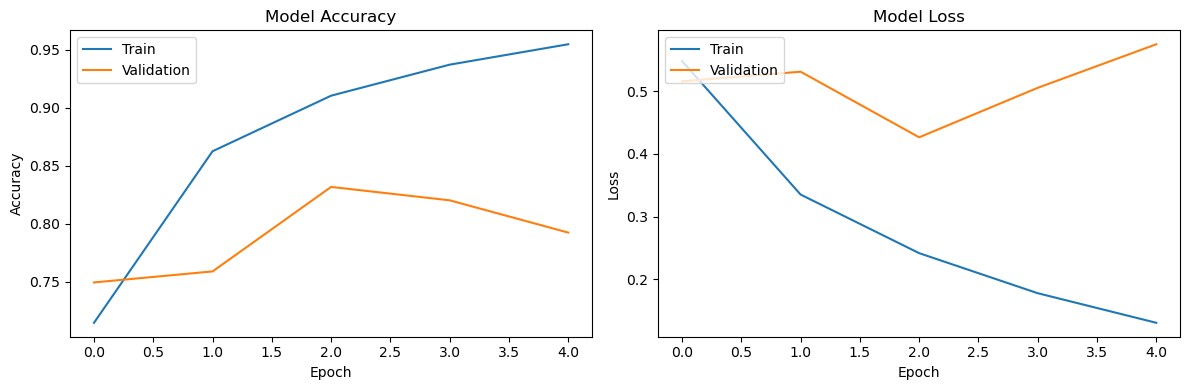

In [83]:
# RNN - sem pre processamento
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Tokeniza as reviews e transforma elas em sequências de inteiros
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_balanced['review'])
X_train = tokenizer.texts_to_sequences(train_data_balanced['review'])
X_test = tokenizer.texts_to_sequences(test_data['review'])

# Pad the sequences so they all have the same length
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Separa os dados em conjuntos de treino e teste
y_train = train_data_balanced['sentiment']
y_test = test_data['sentiment']

# Codifica as classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Cria o modelo RNN
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada de Embedding
model.add(SimpleRNN(32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada SimpleRNN
model.add(Dense(1, activation='sigmoid'))


# Compila o modelo
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Cria o callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Cria o callback de ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

# Treina o modelo e guarda o histórico
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Avalia o modelo
_, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Accuracy: {accuracy}')

# Plota o gráfico de acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plota o gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



**RNN:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm

# Inicializa o tokenizer
tokenizer = Tokenizer()

# Inicializa o modelo RNN
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada de Embedding
model.add(SimpleRNN(32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada SimpleRNN
model.add(Dense(1, activation='sigmoid'))

# Compila o modelo
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Cria o callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Cria o callback de ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

results = []

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    # Aplica métodos de processamento de texto
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.apply(method)
        processed_test = X_test.apply(method)

    # Tokeniza as reviews e transforma elas em sequências de inteiros
    tokenizer.fit_on_texts(processed_train)
    X_train_seq = tokenizer.texts_to_sequences(processed_train)
    X_test_seq = tokenizer.texts_to_sequences(processed_test)

    # Pad the sequences so they all have the same length
    X_train_pad = pad_sequences(X_train_seq, maxlen=100)
    X_test_pad = pad_sequences(X_test_seq, maxlen=100)

    # Codifica as classes de sentimento em valores numéricos
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test) 

    # Treina o modelo e guarda o histórico
    history = model.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

    # Avalia o modelo
    _, accuracy = model.evaluate(X_test_pad, y_test_encoded)

    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
         **report_metrics  # Desempacota as métricas do relatório de classificação
    })

# Converte resultados em DataFrame
results_rnn = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_rnn.to_csv("results_rnn.csv", index=False)

Processing Combinations:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6139 - loss: 0.6529 - val_accuracy: 0.7551 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8183 - loss: 0.4231 - val_accuracy: 0.6090 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8842 - loss: 0.3027 - val_accuracy: 0.7653 - val_loss: 0.5809 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4834


Processing Combinations:   5%|▌         | 1/20 [01:47<34:09, 107.86s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9171 - loss: 0.2244 - val_accuracy: 0.7732 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9400 - loss: 0.1690 - val_accuracy: 0.7635 - val_loss: 0.6392 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7874 - loss: 0.5443


Processing Combinations:  10%|█         | 2/20 [03:30<31:21, 104.55s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9622 - loss: 0.1186 - val_accuracy: 0.7963 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9701 - loss: 0.0940 - val_accuracy: 0.7457 - val_loss: 0.8600 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9790 - loss: 0.0662 - val_accuracy: 0.7389 - val_loss: 0.8619 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7771 - loss: 0.6944


Processing Combinations:  15%|█▌        | 3/20 [03:45<18:06, 63.90s/it] 

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9820 - loss: 0.0543 - val_accuracy: 0.7251 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9902 - loss: 0.0355 - val_accuracy: 0.7493 - val_loss: 0.9840 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7727 - loss: 0.8073


Processing Combinations:  20%|██        | 4/20 [04:00<11:50, 44.40s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5928 - loss: 0.9587 - val_accuracy: 0.5290 - val_loss: 0.7563 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7752 - loss: 0.4706 - val_accuracy: 0.6648 - val_loss: 0.7056 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7359 - loss: 0.5764


Processing Combinations:  25%|██▌       | 5/20 [05:37<15:51, 63.41s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7075 - loss: 0.6028 - val_accuracy: 0.6978 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8550 - loss: 0.3567 - val_accuracy: 0.7396 - val_loss: 0.5844 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.4947


Processing Combinations:  30%|███       | 6/20 [06:40<14:45, 63.25s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6715 - loss: 0.6264 - val_accuracy: 0.7764 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8429 - loss: 0.3693 - val_accuracy: 0.7635 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8881 - loss: 0.2892 - val_accuracy: 0.8439 - val_loss: 0.4087 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9138 - loss: 0.2304 - val_accuracy: 0.7822 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9344 - loss: 0.1868 - val_accuracy: 0.7529 - val_loss: 0.6544 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.5756


Processing Combinations:  35%|███▌      | 7/20 [09:20<20:36, 95.12s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6187 - loss: 0.7401 - val_accuracy: 0.5274 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7947 - loss: 0.4455 - val_accuracy: 0.7484 - val_loss: 0.5652 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7798 - loss: 0.4973


Processing Combinations:  40%|████      | 8/20 [11:05<19:37, 98.14s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6752 - loss: 0.6188 - val_accuracy: 0.5765 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8388 - loss: 0.3757 - val_accuracy: 0.7454 - val_loss: 0.5813 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4941


Processing Combinations:  45%|████▌     | 9/20 [13:40<21:15, 115.96s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6539 - loss: 0.6337 - val_accuracy: 0.6463 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8619 - loss: 0.3407 - val_accuracy: 0.8075 - val_loss: 0.4756 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8392 - loss: 0.4060


Processing Combinations:  50%|█████     | 10/20 [14:27<15:47, 94.73s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6125 - loss: 0.6894 - val_accuracy: 0.5647 - val_loss: 0.7828 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8116 - loss: 0.4230 - val_accuracy: 0.7642 - val_loss: 0.5300 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8142 - loss: 0.4342


Processing Combinations:  55%|█████▌    | 11/20 [14:34<10:08, 67.64s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6471 - loss: 0.6378 - val_accuracy: 0.7323 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8514 - loss: 0.3582 - val_accuracy: 0.7481 - val_loss: 0.5860 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.4673


Processing Combinations:  60%|██████    | 12/20 [16:58<12:08, 91.04s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6692 - loss: 0.6199 - val_accuracy: 0.5475 - val_loss: 0.8778 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8265 - loss: 0.3987 - val_accuracy: 0.7402 - val_loss: 0.5971 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.4781


Processing Combinations:  65%|██████▌   | 13/20 [17:55<09:24, 80.69s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6726 - loss: 0.6230 - val_accuracy: 0.7382 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8454 - loss: 0.3648 - val_accuracy: 0.8136 - val_loss: 0.4354 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.3847


Processing Combinations:  70%|███████   | 14/20 [18:01<05:49, 58.27s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6774 - loss: 0.6156 - val_accuracy: 0.6381 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8483 - loss: 0.3692 - val_accuracy: 0.7511 - val_loss: 0.5321 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4604


Processing Combinations:  75%|███████▌  | 15/20 [18:51<04:37, 55.53s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6834 - loss: 0.6051 - val_accuracy: 0.6966 - val_loss: 0.6215 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8421 - loss: 0.3679 - val_accuracy: 0.7782 - val_loss: 0.4842 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8083 - loss: 0.4279


Processing Combinations:  80%|████████  | 16/20 [20:29<04:33, 68.44s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6402 - loss: 0.6482 - val_accuracy: 0.6797 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8373 - loss: 0.3836 - val_accuracy: 0.6738 - val_loss: 0.6675 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7645 - loss: 0.5253


Processing Combinations:  85%|████████▌ | 17/20 [22:38<04:20, 86.76s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7134 - loss: 0.5637 - val_accuracy: 0.7156 - val_loss: 0.6256 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8550 - loss: 0.3548 - val_accuracy: 0.7671 - val_loss: 0.5302 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8014 - loss: 0.4695


Processing Combinations:  90%|█████████ | 18/20 [22:52<02:09, 64.63s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6739 - loss: 0.6203 - val_accuracy: 0.6779 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8353 - loss: 0.3847 - val_accuracy: 0.7581 - val_loss: 0.5391 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8287 - loss: 0.4140


Processing Combinations:  95%|█████████▌| 19/20 [22:57<00:46, 46.74s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7091 - loss: 0.5678 - val_accuracy: 0.6546 - val_loss: 0.7065 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8518 - loss: 0.3580 - val_accuracy: 0.7556 - val_loss: 0.5706 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7989 - loss: 0.4637


Processing Combinations: 100%|██████████| 20/20 [23:38<00:00, 70.92s/it]


**LSTM (Long Short-Term Memory)**

LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) que é capaz de aprender e lembrar dependências de longo prazo em sequências de dados. 

As RNNs tradicionais têm dificuldade em aprender dependências de longo prazo devido ao chamado problema do desaparecimento do gradiente, onde as informações são perdidas ao longo do tempo. As LSTMs resolvem esse problema com uma estrutura de célula de memória especial que inclui portas para regular o fluxo de informações dentro e fora da célula.

In [ ]:
#LSTM (Long Short-Term Memory)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Aplica a tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Transforma os textos em sequências de inteiros
max_length = 100  # Define o comprimento máximo dos textos após a tokenização
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # Define a dimensão do vetor de embedding


# Codificação das classes de sentimento em valores numéricos
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
model.fit(X_train_seq, y_train_enc, epochs=10, batch_size=128, validation_data=(X_test_seq, y_test_enc))

# Avalia o modelo
loss, accuracy = model.evaluate(X_test_seq, y_test_enc)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Previsões
y_pred = model.predict(X_test_seq)

# Converte probabilidades em classes
y_pred = (y_pred > 0.5).astype(int)

report = classification_report(y_test_enc, y_pred)
print(report)

## 4 Treino de um modelo (aprendizagem automática)

Nesta seção, abordaremos o processo de treinar um modelo de aprendizagem automática com o objetivo de melhorar o desempenho da classificação de dados. Seguiremos os seguintes passos:

## 4.1 Treinamento do Modelo

1. Selecione uma ferramenta de classificação adequada, como **scikit-learn**, TensorFlow, PyTorch, etc.
2. Prepare os dados de treino, garantindo que estão devidamente limpos e formatados para o processo de treinamento.
3. Configure e treine o modelo com o conjunto de dados de treino.

    - Várias configurações podem ser testadas:
        - Número de features.
        - Tratamento de maiúsculas e minúsculas.
        - Diferentes métodos de pré-processamento de texto (normalização, stemming, lematização, etc.).
        - Inclusão ou exclusão de informações de part-of-speech tagging.
        - Utilização de entidades nomeadas reconhecidas no texto.
        - Incorporação de embeddings pré-treinados, como GloVe.
        - Se houver desbalanceamento de classes usar 

## 4.2 Avaliação do Modelo

1. Aplique o modelo treinado ao conjunto de dados de teste.
2. Avalie o desempenho do modelo utilizando métricas adequadas, como precisão, recall, F1-score, etc.
3. Compare os resultados obtidos com os do modelo anterior para avaliar as melhorias.

## 4.3 Documentação e Experimentação

- Realize experimentos variados para entender o impacto de diferentes features e técnicas de pré-processamento.
- Documente cada experimento, incluindo a configuração usada e os resultados obtidos.
- Registre observações e conclusões relevantes a cada experimento.

## 4.4 Referências

- Alguns links que podem ajudar nesta tarefa 
    - https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews#Extracting-Features-from-Cleaned-reviews
    - https://github.com/jesseqzhen/NLP_Sentiment_Analysis
    - https://www.kaggle.com/code/yacharki/binary-classification-amazon-reviews-84-lstm
    - https://www.kaggle.com/code/mammadabbasli/amazon-reviews-analysis-logisticregression

## 5 Utilização de transformadores para classificação

- https://medium.com/@minamehdinia213/fine-tunning-bert-model-for-amazon-product-review-and-deploying-it-into-hugging-face-model-hub-7d259839d556

A aplicação de modelos pré-treinados baseados em transformadores representa uma técnica poderosa no campo da aprendizagem automática, especialmente para tarefas de classificação de texto. O processo será dividido em duas etapas principais, conforme descrito a seguir:

## 5.1 Experimentação com Pipelines Pré-definidos

1. Escolha um ou mais modelos baseados em transformadores disponíveis, como BERT, GPT, Transformer-XL, etc.
2. Utilize pipelines pré-definidos oferecidos por bibliotecas como Hugging Face's Transformers para aplicar rapidamente o modelo aos seus dados.
   
    Exemplos de comandos de pipelines podem incluir:
    
    ```python
    from transformers import pipeline
    classifier = pipeline('text-classification', model='bert-base-uncased')
    ```
    
3. Avalie o desempenho desses modelos em seu conjunto de dados sem qualquer ajuste adicional, usando métricas padrão de classificação.

## 5.2 Fine-tuning de um Modelo Pré-treinado

1. Selecione um modelo pré-treinado apropriado para o seu conjunto de dados e a tarefa de classificação em questão.
2. Adapte o modelo ao seu conjunto de dados específico, o que é conhecido como fine-tuning. Isso envolve o treinamento do modelo em seu conjunto de dados, ajustando os pesos do modelo pré-treinado para melhor se adequar à sua tarefa específica.
3. Durante o fine-tuning, experimente com diferentes hiperparâmetros, como taxa de aprendizado, número de épocas, tamanho do lote e outros relevantes para o modelo escolhido.
   
    Exemplo de código para fine-tuning:
    
    ```python
    from transformers import BertForSequenceClassification, Trainer, TrainingArguments
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    training_args = TrainingArguments(output_dir='./results', num_train_epochs=3, ...)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    
    trainer.train()
    ```
    
4. Após o fine-tuning, avalie novamente o modelo em seu conjunto de dados, usando as mesmas métricas de classificação para comparar o desempenho com o modelo antes do ajuste.

In [66]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Load the tokenizer and model from the Hugging Face Model Hub
model_name = "sbcBI/sentiment_analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("mps")  # Apple's Metal Performance Shaders
model.to(device)
# Create a sentiment analysis pipeline
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

In [71]:
tqdm.pandas()


# Example text
test_data['results'] = test_data['review'].apply(lambda x: sentiment_analysis(x))

# Create a new dictionary with the new keys




In [72]:
def best_sentiment(results):
    # Initialize a dictionary to convert model labels to human-readable labels
    label_mapping = {'LABEL_0': 'negative', 'LABEL_2': 'positive', 'LABEL_1': 'neutral'}
    
    # Sort results by score and filter out 'neutral' unless it's the only option
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])

    return label_mapping[best_result['label']]

# Apply the sentiment analysis and adjust results
test_data['adjusted_results_sbcBI/sentiment_analysis'] = test_data['results'].apply(best_sentiment)

In [73]:
test_data['adjusted_results_sbcBI/sentiment_analysis'].value_counts()

adjusted_results_sbcBI/sentiment_analysis
negative    1212
positive    1205
Name: count, dtype: int64

In [74]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results_sbcBI/sentiment_analysis'])
print(report)

              precision    recall  f1-score   support

    negative       0.56      0.91      0.69       741
    positive       0.94      0.68      0.79      1676

    accuracy                           0.75      2417
   macro avg       0.75      0.79      0.74      2417
weighted avg       0.82      0.75      0.76      2417



In [80]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
tqdm.pandas()


# Example text
test_data['results_distilbert'] = test_data['review'].apply(lambda x: sentiment_analysis(x))


In [82]:
def best_sentiment(results):
    # Initialize a dictionary to convert model labels to human-readable labels
    label_mapping = {'LABEL_0': 'negative', 'LABEL_2': 'positive', 'LABEL_1': 'neutral'}
    
    # Sort results by score and filter out 'neutral' unless it's the only option
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])
    
    for i in best_result:
        print(results)
        
    
    return label_mapping[best_result['label']]

# Apply the sentiment analysis and adjust results
test_data['adjusted_results'] = test_data['results_distilbert'].apply(best_sentiment)

[[{'label': 'LABEL_0', 'score': 0.3586060702800751}, {'label': 'LABEL_1', 'score': 0.31058454513549805}, {'label': 'LABEL_2', 'score': 0.3308093547821045}]]
[[{'label': 'LABEL_0', 'score': 0.3586060702800751}, {'label': 'LABEL_1', 'score': 0.31058454513549805}, {'label': 'LABEL_2', 'score': 0.3308093547821045}]]
[[{'label': 'LABEL_0', 'score': 0.34719711542129517}, {'label': 'LABEL_1', 'score': 0.3201386630535126}, {'label': 'LABEL_2', 'score': 0.33266422152519226}]]
[[{'label': 'LABEL_0', 'score': 0.34719711542129517}, {'label': 'LABEL_1', 'score': 0.3201386630535126}, {'label': 'LABEL_2', 'score': 0.33266422152519226}]]
[[{'label': 'LABEL_0', 'score': 0.346005916595459}, {'label': 'LABEL_1', 'score': 0.31545764207839966}, {'label': 'LABEL_2', 'score': 0.33853647112846375}]]
[[{'label': 'LABEL_0', 'score': 0.346005916595459}, {'label': 'LABEL_1', 'score': 0.31545764207839966}, {'label': 'LABEL_2', 'score': 0.33853647112846375}]]
[[{'label': 'LABEL_0', 'score': 0.35284850001335144}, {'

In [83]:
test_data['adjusted_results'].value_counts()

adjusted_results
negative    2259
positive     158
Name: count, dtype: int64

In [84]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results'])
print(report)

              precision    recall  f1-score   support

    negative       0.32      0.98      0.49       741
    positive       0.92      0.09      0.16      1676

    accuracy                           0.36      2417
   macro avg       0.62      0.53      0.32      2417
weighted avg       0.74      0.36      0.26      2417



In [96]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import os 


if not os.path.exists('./results'):
    os.makedirs('./results')

# Grant write permissions to the directory
os.chmod('./results', 0o777)

#map sentiment to 0 and 1
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
#drop sentiment and change the review and sentiment_converted to text and labels
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})

# Assuming train_data_balanced is defined somewhere
train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizer from the Hugging Face Transformers
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert DataFrame to Dataset to use with Hugging Face's `map` function
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Rename sentiment column to labels for clarity and ensure it's of type torch
# train_dataset = train_dataset.rename_column("sentiment", "labels")
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# val_dataset = val_dataset.rename_column("sentiment", "labels")
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize the Trainer with label names specified
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}  # Example metric function
)

# Start training
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 14682.98 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:15<12:45,  3.19it/s]

{'loss': 0.6927, 'grad_norm': 2.558561325073242, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [00:29<11:30,  3.46it/s]

{'loss': 0.6731, 'grad_norm': 1.7779710292816162, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [00:44<10:52,  3.59it/s]

{'loss': 0.5118, 'grad_norm': 17.64859962463379, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [00:59<11:15,  3.39it/s]

{'loss': 0.4045, 'grad_norm': 7.586021423339844, 'learning_rate': 2e-05, 'epoch': 0.08}



  8%|▊         | 200/2490 [01:18<11:15,  3.39it/s]

{'eval_loss': 0.36884406208992004, 'eval_accuracy': 0.8419150858175248, 'eval_runtime': 18.361, 'eval_samples_per_second': 120.581, 'eval_steps_per_second': 7.57, 'epoch': 0.08}


 10%|█         | 250/2490 [01:33<10:12,  3.66it/s]  

{'loss': 0.3399, 'grad_norm': 1.7672796249389648, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [01:46<09:59,  3.65it/s]

{'loss': 0.3843, 'grad_norm': 2.8235812187194824, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [02:01<09:42,  3.67it/s]

{'loss': 0.4212, 'grad_norm': 0.8824977874755859, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [02:14<09:29,  3.67it/s]

{'loss': 0.4258, 'grad_norm': 9.677887916564941, 'learning_rate': 4e-05, 'epoch': 0.16}



 16%|█▌        | 400/2490 [02:32<09:29,  3.67it/s]

{'eval_loss': 0.4630551040172577, 'eval_accuracy': 0.7836495031616982, 'eval_runtime': 17.9526, 'eval_samples_per_second': 123.325, 'eval_steps_per_second': 7.743, 'epoch': 0.16}


 18%|█▊        | 450/2490 [02:48<09:15,  3.67it/s]  

{'loss': 0.3697, 'grad_norm': 58.41781997680664, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [03:02<09:01,  3.67it/s]

{'loss': 0.4067, 'grad_norm': 3.898305892944336, 'learning_rate': 5e-05, 'epoch': 0.2}


 22%|██▏       | 550/2490 [03:15<08:49,  3.66it/s]

{'loss': 0.3895, 'grad_norm': 14.040782928466797, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [03:29<08:33,  3.68it/s]

{'loss': 0.3362, 'grad_norm': 6.16275691986084, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}



 24%|██▍       | 600/2490 [03:47<08:33,  3.68it/s]

{'eval_loss': 0.41772377490997314, 'eval_accuracy': 0.8604336043360433, 'eval_runtime': 17.8238, 'eval_samples_per_second': 124.216, 'eval_steps_per_second': 7.799, 'epoch': 0.24}


 26%|██▌       | 650/2490 [04:01<08:20,  3.68it/s]  

{'loss': 0.3818, 'grad_norm': 6.647141456604004, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [04:15<08:06,  3.68it/s]

{'loss': 0.4064, 'grad_norm': 5.454117774963379, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [04:29<07:53,  3.67it/s]

{'loss': 0.471, 'grad_norm': 4.42553186416626, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [04:42<07:39,  3.68it/s]

{'loss': 0.3037, 'grad_norm': 13.994978904724121, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}



 32%|███▏      | 800/2490 [05:00<07:39,  3.68it/s]

{'eval_loss': 0.43567612767219543, 'eval_accuracy': 0.8613369467028004, 'eval_runtime': 17.833, 'eval_samples_per_second': 124.152, 'eval_steps_per_second': 7.795, 'epoch': 0.32}


 34%|███▍      | 850/2490 [05:15<07:25,  3.68it/s]  

{'loss': 0.3488, 'grad_norm': 25.521442413330078, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [05:29<08:01,  3.30it/s]

{'loss': 0.3698, 'grad_norm': 15.407140731811523, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [05:45<07:58,  3.22it/s]

{'loss': 0.337, 'grad_norm': 13.640992164611816, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [06:01<07:15,  3.42it/s]

{'loss': 0.3744, 'grad_norm': 11.508125305175781, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}



 40%|████      | 1000/2490 [06:20<07:15,  3.42it/s]

{'eval_loss': 0.30177175998687744, 'eval_accuracy': 0.8753387533875339, 'eval_runtime': 19.3331, 'eval_samples_per_second': 114.519, 'eval_steps_per_second': 7.19, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [06:35<07:01,  3.42it/s]  

{'loss': 0.2864, 'grad_norm': 31.557437896728516, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [06:50<06:41,  3.47it/s]

{'loss': 0.3309, 'grad_norm': 12.816882133483887, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [07:04<06:24,  3.48it/s]

{'loss': 0.3489, 'grad_norm': 3.1772239208221436, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [07:23<10:51,  1.98it/s]

{'loss': 0.265, 'grad_norm': 1.3609901666641235, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}



 48%|████▊     | 1200/2490 [07:54<10:51,  1.98it/s]

{'eval_loss': 0.3234844505786896, 'eval_accuracy': 0.8821138211382114, 'eval_runtime': 31.5228, 'eval_samples_per_second': 70.235, 'eval_steps_per_second': 4.41, 'epoch': 0.48}


 50%|█████     | 1250/2490 [08:17<10:07,  2.04it/s]  

{'loss': 0.3323, 'grad_norm': 1.5357770919799805, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [08:40<08:46,  2.26it/s]

{'loss': 0.3213, 'grad_norm': 7.60746955871582, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [08:57<05:34,  3.41it/s]

{'loss': 0.3799, 'grad_norm': 6.0126729011535645, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [09:12<05:16,  3.44it/s]

{'loss': 0.3182, 'grad_norm': 5.333723545074463, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}



 56%|█████▌    | 1400/2490 [09:32<05:16,  3.44it/s]

{'eval_loss': 0.32243967056274414, 'eval_accuracy': 0.8667570009033424, 'eval_runtime': 19.8487, 'eval_samples_per_second': 111.544, 'eval_steps_per_second': 7.003, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [09:48<05:02,  3.43it/s]  

{'loss': 0.3179, 'grad_norm': 5.199787616729736, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [10:02<04:47,  3.44it/s]

{'loss': 0.2969, 'grad_norm': 2.1543242931365967, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [10:17<04:45,  3.29it/s]

{'loss': 0.2155, 'grad_norm': 14.491832733154297, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [10:34<05:20,  2.78it/s]

{'loss': 0.2904, 'grad_norm': 1.766659140586853, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}



 64%|██████▍   | 1600/2490 [10:58<05:20,  2.78it/s]

{'eval_loss': 0.28342729806900024, 'eval_accuracy': 0.8906955736224029, 'eval_runtime': 23.8441, 'eval_samples_per_second': 92.853, 'eval_steps_per_second': 5.83, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [11:15<04:46,  2.93it/s]  

{'loss': 0.2384, 'grad_norm': 6.88078498840332, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [11:33<04:26,  2.96it/s]

{'loss': 0.3228, 'grad_norm': 7.391086578369141, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [11:50<04:03,  3.03it/s]

{'loss': 0.2968, 'grad_norm': 4.101964473724365, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [12:07<03:44,  3.07it/s]

{'loss': 0.3657, 'grad_norm': 11.448905944824219, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}



 72%|███████▏  | 1800/2490 [12:29<03:44,  3.07it/s]

{'eval_loss': 0.26679110527038574, 'eval_accuracy': 0.8965672990063234, 'eval_runtime': 22.1488, 'eval_samples_per_second': 99.96, 'eval_steps_per_second': 6.276, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [12:47<03:29,  3.06it/s]  

{'loss': 0.3118, 'grad_norm': 5.366739273071289, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [13:03<03:09,  3.12it/s]

{'loss': 0.3162, 'grad_norm': 3.0904548168182373, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [13:19<02:49,  3.18it/s]

{'loss': 0.3105, 'grad_norm': 8.280075073242188, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [13:35<02:37,  3.11it/s]

{'loss': 0.3066, 'grad_norm': 10.349403381347656, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}



 80%|████████  | 2000/2490 [13:57<02:37,  3.11it/s]

{'eval_loss': 0.30126264691352844, 'eval_accuracy': 0.8911472448057814, 'eval_runtime': 21.6056, 'eval_samples_per_second': 102.473, 'eval_steps_per_second': 6.434, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [14:14<02:21,  3.10it/s]

{'loss': 0.346, 'grad_norm': 4.778683662414551, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [14:31<02:21,  2.75it/s]

{'loss': 0.2821, 'grad_norm': 10.008305549621582, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [14:49<01:49,  3.09it/s]

{'loss': 0.2606, 'grad_norm': 11.37336254119873, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [15:06<01:36,  3.01it/s]

{'loss': 0.256, 'grad_norm': 2.2008469104766846, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}



 88%|████████▊ | 2200/2490 [15:29<01:36,  3.01it/s]

{'eval_loss': 0.31438112258911133, 'eval_accuracy': 0.8938572719060524, 'eval_runtime': 23.0476, 'eval_samples_per_second': 96.062, 'eval_steps_per_second': 6.031, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [15:48<01:21,  2.96it/s]

{'loss': 0.334, 'grad_norm': 12.90463924407959, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [16:07<01:02,  3.04it/s]

{'loss': 0.3386, 'grad_norm': 5.280740261077881, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [16:23<00:45,  3.08it/s]

{'loss': 0.3051, 'grad_norm': 4.217113018035889, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [16:39<00:27,  3.27it/s]

{'loss': 0.2192, 'grad_norm': 16.223989486694336, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}



 96%|█████████▋| 2400/2490 [17:00<00:27,  3.27it/s]

{'eval_loss': 0.2856543958187103, 'eval_accuracy': 0.8961156278229448, 'eval_runtime': 20.8565, 'eval_samples_per_second': 106.154, 'eval_steps_per_second': 6.665, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [17:16<00:12,  3.24it/s]

{'loss': 0.2166, 'grad_norm': 17.075998306274414, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [17:29<00:00,  2.37it/s]


{'train_runtime': 1049.8966, 'train_samples_per_second': 18.973, 'train_steps_per_second': 2.372, 'train_loss': 0.349262246357868, 'epoch': 1.0}


100%|██████████| 139/139 [00:21<00:00,  6.36it/s]

{'eval_loss': 0.26679110527038574, 'eval_accuracy': 0.8965672990063234, 'eval_runtime': 22.0083, 'eval_samples_per_second': 100.598, 'eval_steps_per_second': 6.316, 'epoch': 1.0}


In [99]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, Trainer
from sklearn.metrics import classification_report

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Prepare test data
test_data_copy = test_data.copy()
test_data_copy = test_data_copy[['review', 'sentiment']]
test_data_copy.rename(columns={'sentiment': 'labels'}, inplace=True)
test_data_copy.rename(columns={'review': 'text'}, inplace=True)
test_data_copy = test_data_copy[['text', 'labels']]
label_mapping = {'positive': 1, 'negative': 0}
test_data_copy['labels'] = test_data_copy['labels'].map(label_mapping)
test_dataset = Dataset.from_pandas(test_data_copy)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Assuming `trainer` is a pre-initialized Trainer object
predictions = trainer.predict(test_dataset)

# Process predictions
probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

# Classification report
report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

100%|██████████| 152/152 [00:20<00:00,  7.57it/s]


              precision    recall  f1-score   support

    Negative       0.75      0.95      0.84       741
    Positive       0.98      0.86      0.91      1676

    accuracy                           0.89      2417
   macro avg       0.86      0.90      0.87      2417
weighted avg       0.91      0.89      0.89      2417



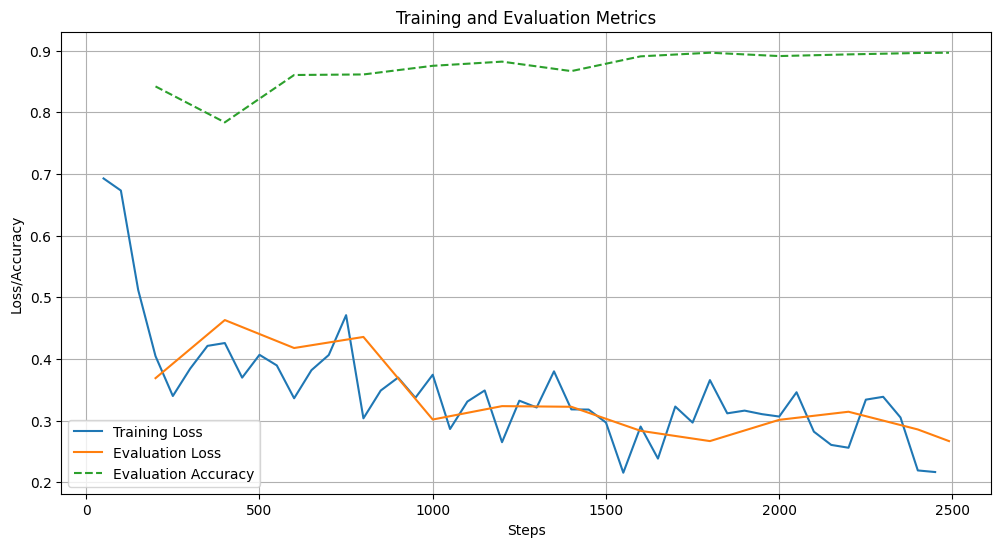

In [100]:
import matplotlib.pyplot as plt

# Assuming 'trainer.state.log_history' contains the logged metrics during training
log_history = trainer.state.log_history

# Extract training and evaluation metrics
training_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
evaluation_logs = [x for x in log_history if 'eval_loss' in x]

# Plotting
plt.figure(figsize=(12, 6))

# Training loss
train_steps = [x['step'] for x in training_logs]
train_loss = [x['loss'] for x in training_logs]
plt.plot(train_steps, train_loss, label='Training Loss')

# Evaluation loss
eval_steps = [x['step'] for x in evaluation_logs]
eval_loss = [x['eval_loss'] for x in evaluation_logs]
eval_accuracy = [x['eval_accuracy'] for x in evaluation_logs]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./saved_model')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [ ]:
sample_text = "This is a very bad movie. I did not really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
model.to(training_args.device)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")

In [101]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import os 




#map sentiment to 0 and 1
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
#drop sentiment and change the review and sentiment_converted to text and labels
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})

#apply clean
train_data_balanced_copy['text'] = train_data_balanced_copy['text'] = train_data_balanced_copy["text"].apply(lambda review: lemmatize(remove_stopwords(expand_contractions(clean(review)))))
#now we have to join the words in the list to form a string
train_data_balanced_copy['text'] = train_data_balanced_copy['text'].apply(lambda x: ' '.join(x))


# Assuming train_data_balanced is defined somewhere
train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizer from the Hugging Face Transformers
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert DataFrame to Dataset to use with Hugging Face's `map` function
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Rename sentiment column to labels for clarity and ensure it's of type torch
# train_dataset = train_dataset.rename_column("sentiment", "labels")
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# val_dataset = val_dataset.rename_column("sentiment", "labels")
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize the Trainer with label names specified
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}  # Example metric function
)

# Start training
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 21160.67 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:14<11:05,  3.66it/s]

{'loss': 0.6905, 'grad_norm': 2.529536008834839, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [00:28<10:37,  3.75it/s]

{'loss': 0.6777, 'grad_norm': 2.0647056102752686, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [00:41<10:50,  3.60it/s]

{'loss': 0.6265, 'grad_norm': 6.2733473777771, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [00:55<10:14,  3.73it/s]

{'loss': 0.5974, 'grad_norm': 6.664205074310303, 'learning_rate': 2e-05, 'epoch': 0.08}



  8%|▊         | 200/2490 [01:13<10:14,  3.73it/s]

{'eval_loss': 0.4853021204471588, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 18.0515, 'eval_samples_per_second': 122.649, 'eval_steps_per_second': 7.7, 'epoch': 0.08}


 10%|█         | 250/2490 [01:27<10:03,  3.71it/s]  

{'loss': 0.4292, 'grad_norm': 14.21162223815918, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [01:41<09:54,  3.68it/s]

{'loss': 0.501, 'grad_norm': 10.271661758422852, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [01:55<09:35,  3.72it/s]

{'loss': 0.5197, 'grad_norm': 11.016067504882812, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [02:08<09:22,  3.71it/s]

{'loss': 0.5097, 'grad_norm': 4.582715034484863, 'learning_rate': 4e-05, 'epoch': 0.16}



 16%|█▌        | 400/2490 [02:26<09:22,  3.71it/s]

{'eval_loss': 0.5396762490272522, 'eval_accuracy': 0.7809394760614273, 'eval_runtime': 17.8749, 'eval_samples_per_second': 123.861, 'eval_steps_per_second': 7.776, 'epoch': 0.16}


 18%|█▊        | 450/2490 [02:41<09:08,  3.72it/s]  

{'loss': 0.5052, 'grad_norm': 11.00912094116211, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [05:12<11:21,  2.92it/s]   

{'loss': 0.4513, 'grad_norm': 3.5076591968536377, 'learning_rate': 5e-05, 'epoch': 0.2}


 22%|██▏       | 550/2490 [14:22<08:55,  3.62it/s]    

{'loss': 0.5138, 'grad_norm': 4.023507595062256, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [26:15<29:10:40, 55.58s/it] 

{'loss': 0.4266, 'grad_norm': 2.580045223236084, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}



 24%|██▍       | 600/2490 [26:34<29:10:40, 55.58s/it]

{'eval_loss': 0.5799745321273804, 'eval_accuracy': 0.7533875338753387, 'eval_runtime': 19.0804, 'eval_samples_per_second': 116.035, 'eval_steps_per_second': 7.285, 'epoch': 0.24}


 26%|██▌       | 650/2490 [26:49<08:15,  3.71it/s]   

{'loss': 0.5741, 'grad_norm': 11.862712860107422, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [27:03<08:03,  3.70it/s]

{'loss': 0.4758, 'grad_norm': 3.836987018585205, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [27:17<07:56,  3.65it/s]

{'loss': 0.4483, 'grad_norm': 7.13626766204834, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [27:31<07:38,  3.68it/s]

{'loss': 0.4418, 'grad_norm': 2.5600829124450684, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}



 32%|███▏      | 800/2490 [27:49<07:38,  3.68it/s]

{'eval_loss': 0.4429713189601898, 'eval_accuracy': 0.8057813911472448, 'eval_runtime': 17.9523, 'eval_samples_per_second': 123.327, 'eval_steps_per_second': 7.743, 'epoch': 0.32}


 34%|███▍      | 850/2490 [28:03<07:21,  3.72it/s]  

{'loss': 0.4055, 'grad_norm': 10.595307350158691, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [28:17<07:07,  3.72it/s]

{'loss': 0.3961, 'grad_norm': 9.207784652709961, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [28:30<07:12,  3.56it/s]

{'loss': 0.3948, 'grad_norm': 6.995338439941406, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [28:44<06:39,  3.73it/s]

{'loss': 0.4358, 'grad_norm': 5.006596565246582, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}



 40%|████      | 1000/2490 [29:02<06:39,  3.73it/s]

{'eval_loss': 0.46287843585014343, 'eval_accuracy': 0.7822944896115628, 'eval_runtime': 18.0004, 'eval_samples_per_second': 122.997, 'eval_steps_per_second': 7.722, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [29:16<06:31,  3.68it/s]  

{'loss': 0.4119, 'grad_norm': 1.9835381507873535, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [29:30<06:13,  3.72it/s]

{'loss': 0.4037, 'grad_norm': 1.4253753423690796, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [29:43<05:59,  3.73it/s]

{'loss': 0.4613, 'grad_norm': 3.2117395401000977, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [29:57<05:46,  3.72it/s]

{'loss': 0.3358, 'grad_norm': 11.234291076660156, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}



 48%|████▊     | 1200/2490 [30:15<05:46,  3.72it/s]

{'eval_loss': 0.4278886616230011, 'eval_accuracy': 0.8301716350496838, 'eval_runtime': 17.9928, 'eval_samples_per_second': 123.049, 'eval_steps_per_second': 7.725, 'epoch': 0.48}


 50%|█████     | 1250/2490 [30:29<05:33,  3.72it/s]  

{'loss': 0.4052, 'grad_norm': 2.054733991622925, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [30:43<05:19,  3.72it/s]

{'loss': 0.4004, 'grad_norm': 3.8373138904571533, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [30:56<05:05,  3.73it/s]

{'loss': 0.404, 'grad_norm': 3.8663346767425537, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [31:10<04:56,  3.67it/s]

{'loss': 0.4126, 'grad_norm': 4.103246688842773, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}



 56%|█████▌    | 1400/2490 [31:28<04:56,  3.67it/s]

{'eval_loss': 0.3972121775150299, 'eval_accuracy': 0.8252032520325203, 'eval_runtime': 17.9916, 'eval_samples_per_second': 123.058, 'eval_steps_per_second': 7.726, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [31:42<04:38,  3.73it/s]  

{'loss': 0.346, 'grad_norm': 5.954625606536865, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [31:56<04:25,  3.73it/s]

{'loss': 0.3779, 'grad_norm': 0.9470037221908569, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [32:09<04:28,  3.50it/s]

{'loss': 0.2965, 'grad_norm': 3.88725209236145, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [32:23<04:00,  3.70it/s]

{'loss': 0.4032, 'grad_norm': 1.0555007457733154, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}



 64%|██████▍   | 1600/2490 [32:41<04:00,  3.70it/s]

{'eval_loss': 0.36014002561569214, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 17.9618, 'eval_samples_per_second': 123.262, 'eval_steps_per_second': 7.739, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [32:55<03:45,  3.73it/s]  

{'loss': 0.3438, 'grad_norm': 9.307290077209473, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [33:09<03:36,  3.64it/s]

{'loss': 0.4332, 'grad_norm': 5.106156826019287, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [33:22<03:18,  3.73it/s]

{'loss': 0.3798, 'grad_norm': 7.608436584472656, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [33:36<03:04,  3.74it/s]

{'loss': 0.3976, 'grad_norm': 3.4196324348449707, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}



 72%|███████▏  | 1800/2490 [33:54<03:04,  3.74it/s]

{'eval_loss': 0.3591669499874115, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 17.9766, 'eval_samples_per_second': 123.16, 'eval_steps_per_second': 7.732, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [34:08<02:52,  3.71it/s]  

{'loss': 0.3623, 'grad_norm': 3.460914134979248, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [34:22<02:40,  3.67it/s]

{'loss': 0.3648, 'grad_norm': 5.503217697143555, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [34:36<02:33,  3.53it/s]

{'loss': 0.3558, 'grad_norm': 6.046627998352051, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [34:51<02:30,  3.27it/s]

{'loss': 0.366, 'grad_norm': 5.626455783843994, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}



 80%|████████  | 2000/2490 [35:12<02:30,  3.27it/s]

{'eval_loss': 0.38230112195014954, 'eval_accuracy': 0.8504968383017163, 'eval_runtime': 20.7694, 'eval_samples_per_second': 106.599, 'eval_steps_per_second': 6.693, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [35:28<02:15,  3.24it/s]

{'loss': 0.4102, 'grad_norm': 7.312149524688721, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [35:44<01:58,  3.28it/s]

{'loss': 0.3711, 'grad_norm': 6.65657901763916, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [35:59<01:42,  3.32it/s]

{'loss': 0.3272, 'grad_norm': 6.68855619430542, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [36:14<01:27,  3.32it/s]

{'loss': 0.3289, 'grad_norm': 6.7072343826293945, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}



 88%|████████▊ | 2200/2490 [36:35<01:27,  3.32it/s]

{'eval_loss': 0.3956999182701111, 'eval_accuracy': 0.8441734417344173, 'eval_runtime': 20.4477, 'eval_samples_per_second': 108.276, 'eval_steps_per_second': 6.798, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [36:51<01:13,  3.25it/s]

{'loss': 0.374, 'grad_norm': 1.0455825328826904, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [37:06<00:58,  3.25it/s]

{'loss': 0.4358, 'grad_norm': 4.759385108947754, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [37:22<00:42,  3.31it/s]

{'loss': 0.3435, 'grad_norm': 5.097073078155518, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [37:37<00:26,  3.34it/s]

{'loss': 0.2878, 'grad_norm': 5.62268590927124, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}



 96%|█████████▋| 2400/2490 [37:58<00:26,  3.34it/s]

{'eval_loss': 0.3640303909778595, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 20.4227, 'eval_samples_per_second': 108.409, 'eval_steps_per_second': 6.806, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [38:14<00:13,  3.07it/s]

{'loss': 0.3313, 'grad_norm': 4.137351036071777, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [38:28<00:00,  1.08it/s]


{'train_runtime': 2308.3391, 'train_samples_per_second': 8.63, 'train_steps_per_second': 1.079, 'train_loss': 0.4260031374582804, 'epoch': 1.0}


100%|██████████| 139/139 [00:20<00:00,  6.66it/s]

{'eval_loss': 0.38230112195014954, 'eval_accuracy': 0.8504968383017163, 'eval_runtime': 21.02, 'eval_samples_per_second': 105.328, 'eval_steps_per_second': 6.613, 'epoch': 1.0}


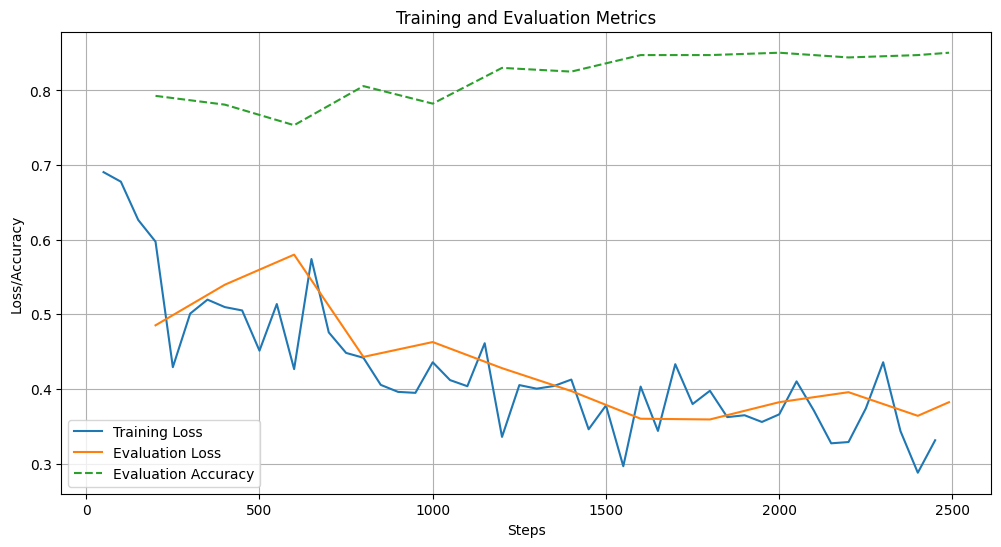

In [104]:
import matplotlib.pyplot as plt

# Assuming 'trainer.state.log_history' contains the logged metrics during training
log_history = trainer.state.log_history

# Extract training and evaluation metrics
training_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
evaluation_logs = [x for x in log_history if 'eval_loss' in x]

# Plotting
plt.figure(figsize=(12, 6))

# Training loss
train_steps = [x['step'] for x in training_logs]
train_loss = [x['loss'] for x in training_logs]
plt.plot(train_steps, train_loss, label='Training Loss')

# Evaluation loss
eval_steps = [x['step'] for x in evaluation_logs]
eval_loss = [x['eval_loss'] for x in evaluation_logs]
eval_accuracy = [x['eval_accuracy'] for x in evaluation_logs]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, Trainer
from sklearn.metrics import classification_report

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Prepare test data
test_data_copy = test_data.copy()
test_data_copy =                                                                                                                                                                                                                                                                                            test_data_copy[['review', 'sentiment']]
test_data_copy.rename(columns={'sentiment': 'labels'}, inplace=True)
test_data_copy.rename(columns={'review': 'text'}, inplace=True)
test_data_copy = test_data_copy[['text', 'labels']]
label_mapping = {'positive': 1, 'negative': 0}
test_data_copy['labels'] = test_data_copy['labels'].map(label_mapping)
test_dataset = Dataset.from_pandas(test_data_copy)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Assuming `trainer` is a pre-initialized Trainer object
predictions = trainer.predict(test_dataset)

# Process predictions
probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

# Classification report
report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

100%|██████████| 152/152 [00:19<00:00,  7.81it/s]


              precision    recall  f1-score   support

    Negative       0.67      0.91      0.77       741
    Positive       0.95      0.81      0.87      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.86      0.82      2417
weighted avg       0.87      0.84      0.84      2417



In [110]:
model_path = "./saved_model_processed"
trainer.save_model(model_path)

In [112]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./saved_model_processed')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [116]:
sample_text = "This is a very bad movie. I did not really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
model.to(training_args.device)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")

Negative sentiment


---------------------------------------------------------------------------

In [118]:
# Model and tokenizer initialization
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification


model_name = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming sentiment analysis with three labels: negative, neutral, positive
device = torch.device("mps")  # Apple's Metal Performance Shaders
model.to(device)
# Create a sentiment analysis pipeline
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
tqdm.pandas()


# Example text
test_data['results_xl_transformers'] = test_data['review'].apply(lambda x: sentiment_analysis(x))



In [ ]:
test_data['results_xl_transformers'] 

In [120]:
def best_sentiment(results):
    
    for i in results:
        print(i)
    # Initialize a dictionary to convert model labels to human-readable labels
    label_mapping = {'LABEL_0': 'negative', 'LABEL_2': 'positive', 'LABEL_1': 'neutral'}
    
    # Sort results by score and filter out 'neutral' unless it's the only option
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])
    
    return label_mapping[best_result['label']]

# Apply the sentiment analysis and adjust results
test_data['adjusted_results'] = test_data['results_xl_transformers'].apply(best_sentiment)

[{'label': 'LABEL_0', 'score': 0.5283176898956299}, {'label': 'LABEL_1', 'score': 0.47168228030204773}]
[{'label': 'LABEL_0', 'score': 0.480172336101532}, {'label': 'LABEL_1', 'score': 0.519827663898468}]
[{'label': 'LABEL_0', 'score': 0.540547251701355}, {'label': 'LABEL_1', 'score': 0.459452748298645}]
[{'label': 'LABEL_0', 'score': 0.5136978030204773}, {'label': 'LABEL_1', 'score': 0.4863021671772003}]
[{'label': 'LABEL_0', 'score': 0.45402947068214417}, {'label': 'LABEL_1', 'score': 0.5459705591201782}]
[{'label': 'LABEL_0', 'score': 0.526088297367096}, {'label': 'LABEL_1', 'score': 0.47391170263290405}]
[{'label': 'LABEL_0', 'score': 0.48958897590637207}, {'label': 'LABEL_1', 'score': 0.5104110240936279}]
[{'label': 'LABEL_0', 'score': 0.5813609957695007}, {'label': 'LABEL_1', 'score': 0.41863900423049927}]
[{'label': 'LABEL_0', 'score': 0.5167867541313171}, {'label': 'LABEL_1', 'score': 0.4832132160663605}]
[{'label': 'LABEL_0', 'score': 0.4836106598377228}, {'label': 'LABEL_1', 

In [121]:
test_data['adjusted_results'].value_counts()

adjusted_results
negative    2417
Name: count, dtype: int64

In [122]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results'], target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.31      1.00      0.47       741
    Positive       0.00      0.00      0.00      1676

    accuracy                           0.31      2417
   macro avg       0.15      0.50      0.23      2417
weighted avg       0.09      0.31      0.14      2417



In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import os 


if not os.path.exists('./results'):
    os.makedirs('./results')

# Grant write permissions to the directory
os.chmod('./results', 0o777)

#map sentiment to 0 and 1
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
#drop sentiment and change the review and sentiment_converted to text and labels
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})

# Assuming train_data_balanced is defined somewhere
train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizer from the Hugging Face Transformers
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert DataFrame to Dataset to use with Hugging Face's `map` function
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Rename sentiment column to labels for clarity and ensure it's of type torch
# train_dataset = train_dataset.rename_column("sentiment", "labels")
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# val_dataset = val_dataset.rename_column("sentiment", "labels")
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=500,
    save_steps=500,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

# Initialize the Trainer with label names specified
trainer_xl = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}  # Example metric function
)

# Start training
trainer_xl.train()

# Evaluate the model
results = trainer_xl.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 12511.24 examples/s]
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:37<29:14,  1.39it/s] 

{'loss': 0.6968, 'grad_norm': 31.673011779785156, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [01:14<28:30,  1.40it/s]

{'loss': 0.5588, 'grad_norm': 33.06428527832031, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [01:52<34:28,  1.13it/s]

{'loss': 0.3338, 'grad_norm': 27.7710018157959, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [02:43<42:04,  1.10s/it]

{'loss': 0.4003, 'grad_norm': 11.279934883117676, 'learning_rate': 2e-05, 'epoch': 0.08}


 10%|█         | 250/2490 [03:38<40:49,  1.09s/it]

{'loss': 0.2978, 'grad_norm': 1.372738003730774, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [04:31<37:53,  1.04s/it]

{'loss': 0.3985, 'grad_norm': 43.27336883544922, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [05:22<35:34,  1.00it/s]

{'loss': 0.4546, 'grad_norm': 2.111199140548706, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [06:12<36:04,  1.04s/it]

{'loss': 0.4408, 'grad_norm': 57.01701736450195, 'learning_rate': 4e-05, 'epoch': 0.16}


 18%|█▊        | 450/2490 [07:06<37:15,  1.10s/it]

{'loss': 0.4187, 'grad_norm': 69.79419708251953, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [08:00<36:00,  1.09s/it]

{'loss': 0.3653, 'grad_norm': 6.679572105407715, 'learning_rate': 5e-05, 'epoch': 0.2}


                                                  
 20%|██        | 500/2490 [09:24<36:00,  1.09s/it]

{'eval_loss': 0.5754261016845703, 'eval_accuracy': 0.8256549232158988, 'eval_runtime': 83.8392, 'eval_samples_per_second': 26.408, 'eval_steps_per_second': 1.658, 'epoch': 0.2}


 22%|██▏       | 550/2490 [10:24<36:51,  1.14s/it]   

{'loss': 0.418, 'grad_norm': 28.472002029418945, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [11:21<34:28,  1.09s/it]

{'loss': 0.3772, 'grad_norm': 34.117347717285156, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}


 26%|██▌       | 650/2490 [12:17<35:38,  1.16s/it]

{'loss': 0.444, 'grad_norm': 10.258790016174316, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [13:13<33:49,  1.13s/it]

{'loss': 0.3515, 'grad_norm': 13.996811866760254, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [14:10<33:16,  1.15s/it]

{'loss': 0.44, 'grad_norm': 14.634058952331543, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [15:06<31:16,  1.11s/it]

{'loss': 0.3807, 'grad_norm': 39.932037353515625, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}


 34%|███▍      | 850/2490 [16:03<31:41,  1.16s/it]

{'loss': 0.3689, 'grad_norm': 1.1981927156448364, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [17:01<30:24,  1.15s/it]

{'loss': 0.3559, 'grad_norm': 45.06592559814453, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [17:59<29:40,  1.16s/it]

{'loss': 0.2991, 'grad_norm': 1.8590494394302368, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [18:57<29:40,  1.19s/it]

{'loss': 0.4495, 'grad_norm': 17.150442123413086, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}


                                                   
 40%|████      | 1000/2490 [20:24<29:40,  1.19s/it]

{'eval_loss': 0.35879507660865784, 'eval_accuracy': 0.8888888888888888, 'eval_runtime': 87.157, 'eval_samples_per_second': 25.402, 'eval_steps_per_second': 1.595, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [21:27<27:25,  1.14s/it]   

{'loss': 0.3114, 'grad_norm': 18.9711856842041, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [22:23<25:51,  1.12s/it]

{'loss': 0.3096, 'grad_norm': 10.55496597290039, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [23:20<24:54,  1.12s/it]

{'loss': 0.3743, 'grad_norm': 5.791611194610596, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [24:16<24:16,  1.13s/it]

{'loss': 0.2808, 'grad_norm': 0.22922150790691376, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}


 50%|█████     | 1250/2490 [25:11<22:36,  1.09s/it]

{'loss': 0.3662, 'grad_norm': 1.321019172668457, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [26:07<22:12,  1.12s/it]

{'loss': 0.3325, 'grad_norm': 7.020089149475098, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [27:04<21:50,  1.15s/it]

{'loss': 0.365, 'grad_norm': 20.001306533813477, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [28:01<21:00,  1.16s/it]

{'loss': 0.3462, 'grad_norm': 29.081035614013672, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [29:00<20:26,  1.18s/it]

{'loss': 0.3396, 'grad_norm': 71.8144302368164, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [29:58<18:31,  1.12s/it]

{'loss': 0.3084, 'grad_norm': 0.2727147340774536, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


                                                   
 60%|██████    | 1500/2490 [31:23<18:31,  1.12s/it]

{'eval_loss': 0.44157424569129944, 'eval_accuracy': 0.8879855465221319, 'eval_runtime': 84.9985, 'eval_samples_per_second': 26.048, 'eval_steps_per_second': 1.635, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [32:24<19:59,  1.28s/it]  

{'loss': 0.2473, 'grad_norm': 0.3525029718875885, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [33:26<17:46,  1.20s/it]

{'loss': 0.338, 'grad_norm': 0.34572088718414307, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [34:26<16:37,  1.19s/it]

{'loss': 0.2779, 'grad_norm': 3.5192177295684814, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [35:26<15:55,  1.21s/it]

{'loss': 0.3165, 'grad_norm': 12.94691276550293, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [36:30<14:35,  1.18s/it]

{'loss': 0.2938, 'grad_norm': 7.7528910636901855, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [37:28<13:38,  1.19s/it]

{'loss': 0.3749, 'grad_norm': 2.435281753540039, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [38:31<15:51,  1.49s/it]

{'loss': 0.3118, 'grad_norm': 0.8150143027305603, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [39:39<11:59,  1.22s/it]

{'loss': 0.3541, 'grad_norm': 1.034761905670166, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [40:39<10:18,  1.15s/it]

{'loss': 0.3536, 'grad_norm': 7.703765392303467, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [41:39<09:28,  1.16s/it]

{'loss': 0.2722, 'grad_norm': 23.00551986694336, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}


                                                   
 80%|████████  | 2000/2490 [43:11<09:28,  1.16s/it]

{'eval_loss': 0.3290601670742035, 'eval_accuracy': 0.9092140921409214, 'eval_runtime': 91.587, 'eval_samples_per_second': 24.174, 'eval_steps_per_second': 1.518, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [44:14<10:06,  1.38s/it]  

{'loss': 0.4637, 'grad_norm': 2.7203493118286133, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [45:14<07:29,  1.15s/it]

{'loss': 0.1963, 'grad_norm': 0.4795510470867157, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [46:12<06:36,  1.17s/it]

{'loss': 0.3055, 'grad_norm': 10.272490501403809, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [47:10<05:33,  1.15s/it]

{'loss': 0.2937, 'grad_norm': 0.49307993054389954, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [48:10<05:19,  1.33s/it]

{'loss': 0.2798, 'grad_norm': 2.705646514892578, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [49:12<03:47,  1.20s/it]

{'loss': 0.3399, 'grad_norm': 8.402851104736328, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [50:10<02:43,  1.17s/it]

{'loss': 0.3799, 'grad_norm': 4.130214214324951, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [51:08<01:53,  1.26s/it]

{'loss': 0.2227, 'grad_norm': 40.11537170410156, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [52:07<00:45,  1.14s/it]

{'loss': 0.2325, 'grad_norm': 25.134103775024414, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [52:54<00:00,  1.27s/it]


{'train_runtime': 3174.5316, 'train_samples_per_second': 6.275, 'train_steps_per_second': 0.784, 'train_loss': 0.3560879090703635, 'epoch': 1.0}


100%|██████████| 139/139 [01:29<00:00,  1.55it/s]

{'eval_loss': 0.3290601670742035, 'eval_accuracy': 0.9092140921409214, 'eval_runtime': 90.3762, 'eval_samples_per_second': 24.498, 'eval_steps_per_second': 1.538, 'epoch': 1.0}


In [9]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, Trainer
from sklearn.metrics import classification_report

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Prepare test data
test_data_xl = test_data.copy()
test_data_xl = test_data_xl[['review', 'sentiment']]
test_data_xl.rename(columns={'sentiment': 'labels'}, inplace=True)
test_data_xl.rename(columns={'review': 'text'}, inplace=True)
test_data_xl = test_data_xl[['text', 'labels']]
label_mapping = {'positive': 1, 'negative': 0}
test_data_xl['labels'] = test_data_xl['labels'].map(label_mapping)
test_dataset = Dataset.from_pandas(test_data_xl)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Assuming `trainer` is a pre-initialized Trainer object
predictions = trainer_xl.predict(test_dataset)

# Process predictions
probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

# Classification report
report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

Map: 100%|██████████| 2417/2417 [00:00<00:00, 9009.65 examples/s]
163it [02:09,  1.25it/s]                         

              precision    recall  f1-score   support

    Negative       0.79      0.94      0.86       741
    Positive       0.97      0.89      0.93      1676

    accuracy                           0.91      2417
   macro avg       0.88      0.92      0.89      2417
weighted avg       0.92      0.91      0.91      2417



In [10]:
model.save_pretrained('./saved_model_transformers_XL')
tokenizer.save_pretrained('./saved_model_transformers_XL')

('./saved_model_transformers_XL/tokenizer_config.json',
 './saved_model_transformers_XL/special_tokens_map.json',
 './saved_model_transformers_XL/tokenizer.json')

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./saved_model_transformers_XL')
tokenizer = AutoTokenizer.from_pretrained("saved_model_transformers_XL")


In [13]:
sample_text = "This is a very bad movie. I did not really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
model.to(training_args.device)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")


Negative sentiment


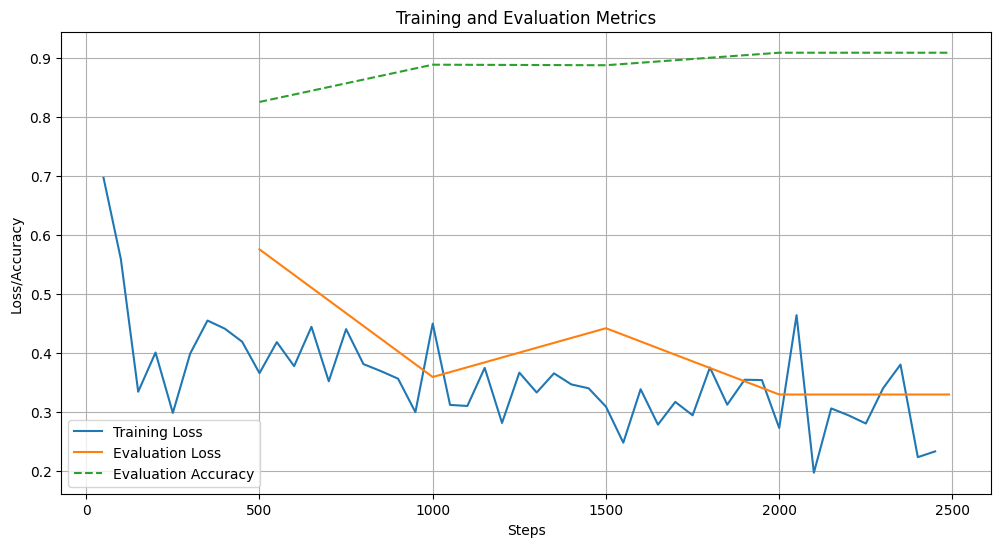

In [14]:
import matplotlib.pyplot as plt

# Assuming 'trainer.state.log_history' contains the logged metrics during training
log_history = trainer_xl.state.log_history

# Extract training and evaluation metrics
training_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
evaluation_logs = [x for x in log_history if 'eval_loss' in x]

# Plotting
plt.figure(figsize=(12, 6))

# Training loss
train_steps = [x['step'] for x in training_logs]
train_loss = [x['loss'] for x in training_logs]
plt.plot(train_steps, train_loss, label='Training Loss')

# Evaluation loss
eval_steps = [x['step'] for x in evaluation_logs]
eval_loss = [x['eval_loss'] for x in evaluation_logs]
eval_accuracy = [x['eval_accuracy'] for x in evaluation_logs]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Coisas a fazer
    - Tentar meter reprodutibilidade 
    - treinar com metodos de processamento de texto e testar nos transformers
    